In [1]:
from utils_v1 import *


In [2]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import pathlib
import cv2
import sys
import numpy as np
from src import metrics as _metrics
from src.dataset import (
    MultipleDates,
    Para, ParaDeforestationTime, ParaDistanceMap, ParaMultipleDates,
    MTDeforestationTime,
    MTMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates


In [3]:
# dataset = ParaDeforestationTime()
addPastDeforestationInput = True

# dataset = ParaMultipleDates(dates = [2018, 2019], # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
# 	addPastDeforestationInput = addPastDeforestationInput,
# 	borderBuffer = 2)	
dataset = MTMultipleDates(dates = [2019, 2020], # dates = [2016,2017,2018,2019]
	addPastDeforestationInput = addPastDeforestationInput,
	borderBuffer = 2)	
# dataset = MTDeforestationTime()	
# [2016, 2017, 2018]
# dataset = Para()
if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)
else:
	patchesHandler = PatchesHandler()

inference_times = 10

training = False
save_probabilities = True
loadInference = False
if training == False:
	if type(dataset) == Para:
		exp = 2

	if type(dataset) == ParaDeforestationTime:
		# exp = 3 # uses past deforestation mask until 2020, which is a mistake. use it until 2018
		exp = 4 # uses past deforestation mask without dates.
		exp = 5 # uses past deforestation mask with dates. 38 epochs.
		exp = 5 # fixes mask.
		exp = 6 # uses past deforestation distance and past deforestation. didnt test it yet        
		exp = 8 # Uses fixed past deforestation distance and past deforestation. 98.9 mAP
		exp = 9 # dummy for coords. high mAP. 99.8.   
		exp = 10 # using fixed fixed past deforestation distance. mAP 90.7   
		exp = 12 # Multiple dates. using fixed fixed past deforestation distance. mAP reduced to 89.6
	if type(dataset) == ParaDistanceMap:
		exp = 7 # not so good result.
	if type(dataset) == ParaMultipleDates:
		exp = 11 # Multiple dates. using fixed fixed past deforestation distance
		exp = 22
		exp = 50
		exp = 52
		# exp = 54
		exp = 56
		exp = 58
		# exp = 63
		# exp = 52
		# exp = 64
		# exp = 66
		exp = 66
		exp = 68
		
		# =============
		# exp = 72 # train 2015-2018
		# exp = 69 # train 2016-2018
		# exp = 70 # train 2017-2018
		
		# train 2018-2019. test 2018-2019
		# exp = 39 # old 
		exp = 76 # 88.4 mAP
		# exp = 71 # 89.5 mAP

		# =============
		
		### exp = 73
		# exp = 71
		# exp = 61

		exp = 77 # good?
		# exp = 78 # good but too short?

		exp = 90 # good result. label ok. f1 84.4 train 2018-2019
		exp = 92 # train 2017-2018
		exp = 93 # train 2016-2018
		exp = 94 # train 2015-2018
		
		exp = 96 # train 2018-2019
		exp = 97 # train 2017-2018
		exp = 98 # train 2016-2018
		exp = 99 # train 2015-2018
	if type(dataset) == MTDeforestationTime:
		exp = 28
	if type(dataset) == MTMultipleDates:
		exp = 73 # train 2018-2019
		# exp = 74 # train 2016-2019
		# exp = 75 # train 2017-2019
		
		exp = 78 # 2019-2020

		# exp = 88 adds project past deforestation to label
		exp = 89 # ok label. so so result
		
		exp = 91 # ok label. Good result. 81.8 F1. train 2019-2020
		exp = 95 # train 2018-2019
		exp = 100 # train 2017-2019
else:
	# exp = 13 # Multiple dates. using fixed fixed past deforestation distance
	exp = 101

ic| list(self.date_ids): [0, 1]
ic| self.image_channels: [[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
                          [1,
                           12,
                           13,
                           14,
                           15,
                           16,
                           17,
                           18,
                           19,
                           20,
                           21,
                           22,
                           23,
                           24,
                           25,
                           26,
                           27,
                           28,
                           29,
                           30,
                           31]]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
                                  [1,
                                  

In [4]:
exp

100

In [5]:
figures_path = 'figures' + dataset.__class__.__name__ + '/'
pathlib.Path(figures_path).mkdir(parents=True, exist_ok=True)
title_name = 'ResUnet'

In [6]:
# ic(type(dataset), exp, dataset.dates)


In [7]:
# Loading reference
label_mask = dataset.loadLabel()
print('Mask label shape: ', '\n', label_mask.shape, '\n', 'Unique values: ', '\n', np.unique(label_mask))

D:/Jorge/datasets/deforestation/MT/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2018) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


D:/Jorge/datasets/deforestation/MT/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2018) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 2)


Mask label shape:  
 (16795, 10420, 2) 
 Unique values:  
 [0 1 2]


In [8]:
# np.save('label_not_independent.npy', label_mask)


In [9]:
# Creating tile mask

mask_tiles = create_mask(label_mask.shape[0], label_mask.shape[1], 
        grid_size=(dataset.grid_x, dataset.grid_y))
label_mask = label_mask[:mask_tiles.shape[0], :mask_tiles.shape[1]]

Tiles size:  3359 2084
Mask size:  (16795, 10420)


In [10]:
label_mask.dtype

dtype('uint8')

In [11]:
label_mask_current_deforestation = dataset.getLabelCurrentDeforestation(
        label_mask)

In [12]:
label_mask.dtype

dtype('uint8')

In [13]:
# Loading image stack
image_stack = dataset.loadInputImage()

print('Image shape: ', image_stack.shape)
channels = image_stack.shape[-1]
image_stack = image_stack[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
print('mask: ',mask_tiles.shape)
print('image stack: ', image_stack.shape)
print('ref :', label_mask.shape)
#plt.imshow(mask_tiles)

ic| image_stack.shape: (16795, 10420, 32)


Image shape:  (16795, 10420, 32)
mask:  (16795, 10420)
image stack:  (16795, 10420, 32)
ref : (16795, 10420, 2)


In [14]:
np.unique(image_stack[...,0], return_counts=True)

(array([0.        , 0.09090909, 0.18181819, 0.27272728, 0.36363637,
        0.45454547, 0.54545456, 0.6363636 , 0.72727275, 0.8181819 ,
        0.90909094, 1.        ], dtype=float32),
 array([115768911,   1098901,   1007787,    876898,    648966,    708581,
           287191,    313901,    338545,    240796,   1332783,  52380640],
       dtype=int64))

(-0.5, 10419.5, 16794.5, -0.5)

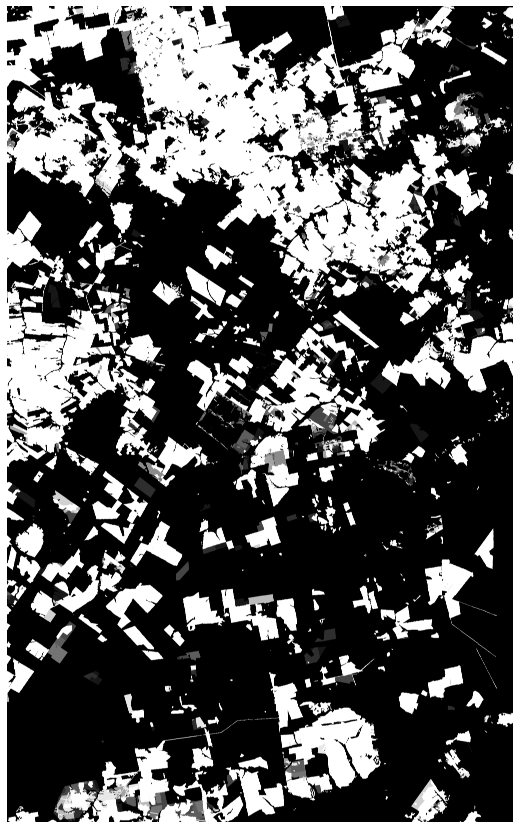

In [15]:


plt.figure(figsize=(15,15))
plt.imshow(image_stack[...,0], cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [16]:
ic(image_stack.shape)
channels = image_stack.shape[-1]
ic(channels)

ic| image_stack.shape: (16795, 10420, 32)
ic| channels: 32


32

In [17]:
mask_tr_val, mask_amazon_ts = dataset.getTrainValTestMasks(mask_tiles)


Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]


In [18]:

patch_size = 128
if training == True:

    # Extracting patches from the idx matrix
    overlap = 0.7
    batch_size = 32
    im_idx = patchesHandler.create_idx_image(label_mask)


ic| im_idx_row.shape: (16795, 10420, 1)
    im_idx_col.shape: (16795, 10420, 1)
ic| im_idx_row.dtype: dtype('uint16')
    im_idx_col.dtype: dtype('uint16')
ic| im_idx.shape: (16795, 10420, 2), im_idx.dtype: dtype('uint16')


In [19]:
import importlib
if training == True:
	coords = patchesHandler.extract_patches(
		im_idx, patch_size=(patch_size, patch_size, 2), 
		overlap=overlap)

	coords_train, coords_val = patchesHandler.trainTestSplit(coords,
		mask_tr_val, patch_size=(patch_size, patch_size, 2))

	ic(coords_train.shape, coords_val.shape)
	# del im_idx

ic| coords.shape: (439, 271, 1, 128, 128, 2)
    coords.dtype: dtype('uint16')
ic| coords.shape: (118969, 2), coords.dtype: dtype('uint16')
ic| coords_train.shape: (173485, 3), coords_val.shape: (13175, 3)


In [20]:
label_mask.shape

(16795, 10420, 2)

(-0.5, 10419.5, 16794.5, -0.5)

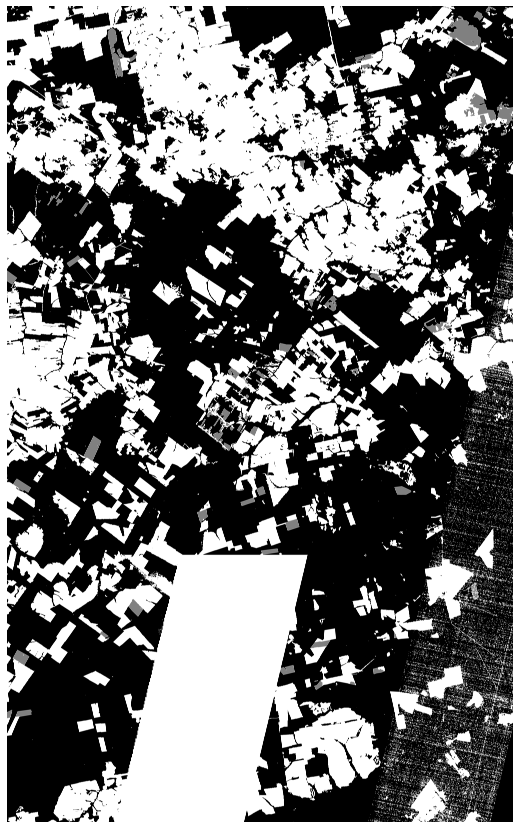

In [21]:

plt.figure(figsize=(15,15))
if type(dataset) != ParaDeforestationTime and type(dataset) != MTDeforestationTime:
    plt.imshow(label_mask[...,-1], cmap=plt.cm.gray)
else:
    plt.imshow(label_mask, cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [22]:
np.unique(label_mask)

array([0, 1, 2], dtype=uint8)

In [23]:
if training == True:
    print(coords_train)

[[    0     0     0]
 [    0    38     0]
 [    0    76     0]
 ...
 [16644  8132     1]
 [16644  8170     1]
 [16644  8208     1]]


In [24]:
if training == True:

    # Keeping patches with 2% of def class
    coords_train = patchesHandler.retrieve_idx_percentage(label_mask, coords_train, 
			patch_size, pertentage = 0.2)
    coords_val = patchesHandler.retrieve_idx_percentage(label_mask, coords_val, 
			patch_size, pertentage = 0.2)
    print('training samples: ', coords_train.shape, 
			'validation samples: ', coords_val.shape)


training samples:  (6459, 3) validation samples:  (623, 3)


In [25]:
'''
import src.patchesHandler as sp
importlib.reload(sp)

patchesHandler = sp.PatchesHandlerMultipleDates(
		dataset)
'''

'\nimport src.patchesHandler as sp\nimportlib.reload(sp)\n\npatchesHandler = sp.PatchesHandlerMultipleDates(\n\t\tdataset)\n'

In [26]:
import src.plot as _plt
importlib.reload(_plt)

<module 'src.plot' from 'd:\\Jorge\\deforestation_uncertainty\\src\\plot.py'>

In [27]:
'''
if training == True:
    idx = 3100
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))
    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], 
            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],
            image_stack[...,[44,45,46]],            
            lims = None, 
            titles = ['2015', '2016', '2017', '2018', '2019'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False, False],
            invertMask = [False, False, False, False, False])
'''

"\nif training == True:\n    idx = 3100\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))\n    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], \n            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],\n            image_stack[...,[44,45,46]],            \n            lims = None, \n            titles = ['2015', '2016', '2017', '2018', '2019'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False, False],\n            invertMask = [False, False, False, False, False])\n"

In [28]:
inputSnipShow = False

In [29]:
if training == True and inputSnipShow == True:
    idx = 2800
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [30]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [31]:
if training == True and inputSnipShow == True:

    idx = 97
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [32]:
if training == True and inputSnipShow == True:

    idx = 1200
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [33]:
inputSnipShow = False
if training == True and inputSnipShow == True:

    idx = 400
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [34]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [35]:
# Creating train and validation data generator
# importlib.reload(patchesHandler)
import pdb
if training == True:

	train_datagen = ImageDataGenerator()
	valid_datagen = ImageDataGenerator()
	# pdb.set_trace()
	len_X_train = coords_train.shape[0]
	len_X_valid = coords_val.shape[0]

	train_gen = train_datagen.flow(
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=True)
	# pdb.set_trace()

	valid_gen = valid_datagen.flow(
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=False)

	number_class = 3
	train_gen_batch = patchesHandler.batch_generator(train_gen,
			image_stack, label_mask, patch_size, number_class)
	valid_gen_batch = patchesHandler.batch_generator(valid_gen,
			image_stack, label_mask, patch_size, number_class)

	#del image_stack

In [36]:
# Creating folder for the experiment

path_exp = dataset.paths.experiment + 'exp' + str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)
    
times = 1
method = 'resunet'
nb_filters = [16, 32, 64, 128, 256]
weights = [0.1, 0.9, 0]

In [37]:
if type(patchesHandler) == PatchesHandlerMultipleDates:
	channels = patchesHandler.input_image_shape

In [38]:
path_exp

'D:/Jorge/datasets/deforestation/experiments/MT/exp100'

In [39]:
channels

21

In [40]:
image_stack.shape

(16795, 10420, 32)

In [41]:

metrics_all = []
if training == True:
    for tm in range(0,times):
        print('time: ', tm)

        rows = patch_size
        cols = patch_size
        adam = Adam(lr = 1e-3 , beta_1=0.9)
        
        loss = weighted_categorical_crossentropy(weights)
        input_shape = (rows, cols, channels)
        model = build_resunet_dropout_spatial(input_shape, nb_filters, number_class)
        
        model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
        model.summary()

        earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
        checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
        callbacks_list = [earlystop, checkpoint]
        # train the model
        start_training = time.time()
        history = model.fit_generator(train_gen_batch,
                                steps_per_epoch=len_X_train*3//train_gen.batch_size,
                                validation_data=valid_gen_batch,
                                validation_steps=len_X_valid*3//valid_gen.batch_size,
                                epochs=100,
                                callbacks=callbacks_list)
        end_training = time.time() - start_training
        # metrics_all.append(end_training)
        del model, history

    # Saving training time
    # np.save(path_exp+'/metrics_tr.npy', metrics_all)
    del train_gen_batch, valid_gen_batch

time:  0


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_enc_net (InputLayer)      [(None, 128, 128, 21 0                                            
__________________________________________________________________________________________________
res1_net1 (Conv2D)              (None, 128, 128, 16) 3040        input_enc_net[0][0]              
__________________________________________________________________________________________________
drop_net1 (SpatialDropout2D)    (None, 128, 128, 16) 0           res1_net1[0][0]                  
__________________________________________________________________________________________________
res2_net1 (Conv2D)              (None, 128, 128, 16) 2320        drop_net1[0][0]                  
______________________________________________________________________________________________

c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


605/605 [==============================] - 61s 87ms/step - loss: 0.0644 - accuracy: 0.8660 - val_loss: 0.0400 - val_accuracy: 0.9411

Epoch 00001: val_loss improved from inf to 0.04000, saving model to D:/Jorge/datasets/deforestation/experiments/MT/exp100/models\resunet_0.h5
Epoch 2/100
  1/605 [..............................] - ETA: 36s - loss: 0.0572 - accuracy: 0.8576

c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


605/605 [==============================] - 51s 85ms/step - loss: 0.0483 - accuracy: 0.9023 - val_loss: 0.0357 - val_accuracy: 0.9429

Epoch 00002: val_loss improved from 0.04000 to 0.03568, saving model to D:/Jorge/datasets/deforestation/experiments/MT/exp100/models\resunet_0.h5
Epoch 3/100
605/605 [==============================] - 52s 85ms/step - loss: 0.0437 - accuracy: 0.9089 - val_loss: 0.0265 - val_accuracy: 0.9470

Epoch 00003: val_loss improved from 0.03568 to 0.02647, saving model to D:/Jorge/datasets/deforestation/experiments/MT/exp100/models\resunet_0.h5
Epoch 4/100
605/605 [==============================] - 52s 86ms/step - loss: 0.0407 - accuracy: 0.9128 - val_loss: 0.0290 - val_accuracy: 0.9472

Epoch 00004: val_loss did not improve from 0.02647
Epoch 5/100
605/605 [==============================] - 52s 86ms/step - loss: 0.0386 - accuracy: 0.9156 - val_loss: 0.0271 - val_accuracy: 0.9481

Epoch 00005: val_loss did not improve from 0.02647
Epoch 6/100
605/605 [=============

In [42]:
image_stack.shape

(16795, 10420, 32)

In [43]:
if type(dataset) != ParaDeforestationTime and type(dataset) != MTDeforestationTime:
    patchesHandler.dataset.image_channels[-1]

In [44]:
if type(dataset) == ParaMultipleDates:
	channels = patchesHandler.input_image_shape
	image_stack = image_stack[..., patchesHandler.dataset.image_channels[-1]]
	label_mask = label_mask[...,-1]

In [45]:
image_stack.shape

(16795, 10420, 32)

In [46]:
#%% Test loop

metrics_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_stack.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_stack, pad_width=npad, mode='reflect')
# del image_stack


-5.0 -12.0


In [47]:

h, w, c = image1_pad.shape
c = channels
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

ic(path_models+ '/' + method +'_'+str(0)+'.h5')
model = load_model(path_models+ '/' + method +'_'+str(0)+'.h5', compile=False)
class_n = 3

if loadInference == False:
    if save_probabilities == False:
        # prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, inference_times), dtype = np.float32)
        prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], inference_times), dtype = np.float32)

    new_model = utils_v1.build_resunet_dropout_spatial(input_shape=(patch_size_rows,patch_size_cols, c), 
        nb_filters = nb_filters, n_classes = class_n, dropout_seed = None)

    for l in range(1, len(model.layers)):
        new_model.layers[l].set_weights(model.layers[l].get_weights())
    
            

    metrics_all =[]
    with tf.device('/cpu:0'):
        for tm in range(0,inference_times):
            print('time: ', tm)

            
            # Recinstructing predicted map
            start_test = time.time()
            '''
            args_network = {'patch_size_rows': patch_size_rows,
                'patch_size_cols': patch_size_cols,
                'c': c,
                'nb_filters': nb_filters,
                'class_n': class_n,
                'dropout_seed': inference_times}
            '''
            prob_reconstructed = patchesHandler.infer(
                    new_model, image1_pad, h, w, 
                    # model, image1_pad, h, w, 
                    num_patches_x, num_patches_y, patch_size_rows, 
                    patch_size_cols)
                    # patch_size_cols, a = args_network)
                    
            ts_time =  time.time() - start_test

            if save_probabilities == True:
                np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
            else:
                prob_rec[:,:,tm] = prob_reconstructed
            
            metrics_all.append(ts_time)
            del prob_reconstructed
        metrics_ = np.asarray(metrics_all)
        # Saving test time
        np.save(path_exp+'/metrics_ts.npy', metrics_)


ic| path_models+ '/' + method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/MT/exp100/models/resunet_0.h5'


time:  0


ValueError: in user code:

    c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1584 predict_function  *
        return step_function(self, iterator)
    c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1574 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1567 run_step  **
        outputs = model.predict_step(data)
    c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1540 predict_step
        return self(x, training=False)
    c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1040 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:267 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_1: expected shape=(None, 3360, 2608, 21), found shape=(None, 3360, 2608, 32)


In [ ]:
'''
with tf.device('/cpu:0'):
    for tm in range(0,times):
        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) 
'''

"\nwith tf.device('/cpu:0'):\n    for tm in range(0,times):\n        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) \n"

In [ ]:
del image1_pad


In [ ]:
# if loadInference == True:
if save_probabilities == True:
    prob_rec = np.zeros((h, w, inference_times), dtype = np.float32)

    for tm in range(0, inference_times):
        print(tm)
        prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)




0
1
2
3
4
5
6
7
8
9


In [ ]:
useLessInferenceRuns = False
if useLessInferenceRuns == True:

    reducedInferenceRuns = 3
    # prob_rec_all = prob_rec.copy()
    prob_rec = prob_rec_all[:reducedInferenceRuns]
    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))


In [ ]:
prob_rec.shape

(17760, 9216, 10)

In [ ]:
prob_rec.shape

(17760, 9216, 10)

In [ ]:
mean_prob = np.mean(prob_rec, axis = -1)
# np.save(path_maps+'/prob_mean.npy', mean_prob)


In [ ]:
ic(np.min(mean_prob), np.mean(mean_prob), np.max(mean_prob))

ic| np.min(mean_prob): 6.4849754e-24
    np.mean(mean_prob): 0.01462198
    np.max(mean_prob): 0.999987


(6.4849754e-24, 0.01462198, 0.999987)

In [ ]:
ic(mean_prob.shape)

ic| mean_prob.shape: (17760, 9216)


(17760, 9216)

In [ ]:
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
'''
ref1 = np.ones_like(label_mask).astype(np.float32)

ref1 [label_mask == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = label_mask==1
'''


'\nref1 = np.ones_like(label_mask).astype(np.float32)\n\nref1 [label_mask == 2] = 0\nTileMask = mask_amazon_ts * ref1\nGTTruePositives = label_mask==1\n'

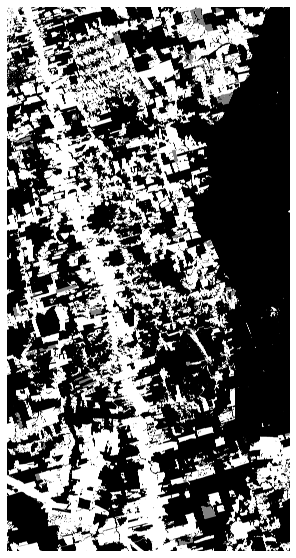

In [ ]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [ ]:
if issubclass(type(dataset), MultipleDates):
    label_mask = np.squeeze(label_mask)

In [ ]:
mean_prob.shape

(17730, 9200)

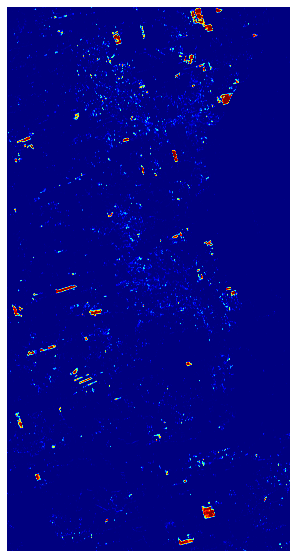

In [ ]:
mean_prob = mean_prob.copy()
mean_prob[label_mask == 2] = 0
fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [ ]:
# print(np.unique(label_mask, return_counts=True))
print(label_mask.shape)

(17730, 9200)


In [ ]:
label_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]
mean_prob_test = mean_prob_test[label_test != 2]
label_test = label_test[label_test != 2]

print(label_test.shape)
print(np.unique(label_test, return_counts=True))

(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))


In [ ]:
from sklearn import metrics
mAP = round(metrics.average_precision_score(label_test, 
        mean_prob_test)*100, 2)
print(mAP)

86.19


In [ ]:
from icecream import ic

ic(prob_rec.shape)
prob_rec = np.transpose(prob_rec, (2, 0, 1))


ic| prob_rec.shape: (17760, 9216, 10)


In [ ]:
prob_rec = np.expand_dims(prob_rec, axis = -1)

In [ ]:
ic(prob_rec.shape)

ic| prob_rec.shape: (10, 17760, 9216, 1)


(10, 17760, 9216, 1)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epsilon = 1e-15
def show_im(im, ax, title = "", cmap = "jet"):
    im_plt = ax.imshow(im.astype(np.float32), cmap = cmap)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 

def get_mean(pred_probs):
      return np.mean(pred_probs, axis=0)
    
def get_uncertainty_var(pred_probs):
    return np.var(pred_probs, axis=0)
    
def predictive_variance(pred_probs):
    pred_var = get_uncertainty_var(pred_probs)
    pred_var = np.average(pred_var, axis = -1)
#    ic(pred_var.shape)
    return pred_var

def predictive_entropy(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    pred_entropy = np.zeros((pred_mean.shape[0:2]))

    K = pred_mean.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_mean[..., k] * np.log(pred_mean[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy


def single_experiment_entropy(pred_prob):
    pred_entropy = np.zeros(pred_prob.shape[0:2])
    ic(pred_entropy.shape)
    
    K = pred_prob.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_prob[..., k] * np.log(pred_prob[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy

def mutual_information(pred_probs):
    H = predictive_entropy(pred_probs)
    sum_entropy = 0

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]
    ic(n, K)

    for i in range(n):
        for k in range(K):
            sum_entropy = sum_entropy + pred_probs[i, ..., k] * np.log(pred_probs[i, ..., k] + epsilon)

    sum_entropy = - sum_entropy / (n * K)

    MI = H - sum_entropy
    return MI

In [ ]:
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))
ic(prob_rec.shape)

ic| np.min(prob_rec): 0.0
    np.mean(prob_rec): 0.0146207
    np.max(prob_rec): 1.0
ic| prob_rec.shape: (10, 17760, 9216, 1)


(10, 17760, 9216, 1)

In [ ]:
pred_entropy = predictive_entropy(prob_rec).astype(np.float32)
pred_entropy_to_show = pred_entropy.copy()[:label_mask.shape[0], :label_mask.shape[1]]

pred_entropy_to_show[label_mask == 2] = 0



In [ ]:
ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))
ic(pred_entropy.shape, pred_entropy_to_show.shape)

ic| np.min(pred_entropy_to_show): 0.0
    np.mean(pred_entropy_to_show): 0.013424433
    np.max(pred_entropy_to_show): 0.36787948
ic| np.min(pred_entropy): 2.239831e-22
    np.mean(pred_entropy): 0.014229346
    np.max(pred_entropy): 0.36787948
ic| pred_entropy.shape: (17760, 9216)
    pred_entropy_to_show.shape: (17730, 9200)


((17760, 9216), (17730, 9200))

In [ ]:
prob_rec.shape

(10, 17760, 9216, 1)

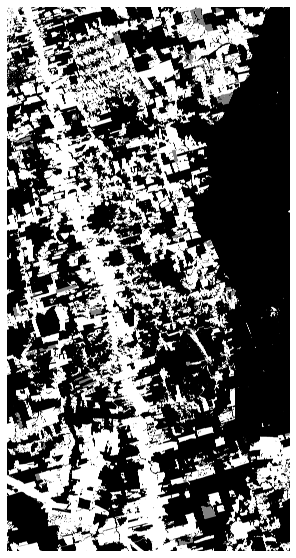

In [ ]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [ ]:
# Computing error mask
# label_mask
'''
for idx in range(10):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(prob_rec[idx], cmap = 'jet')
# fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')
'''

"\nfor idx in range(10):\n    fig, ax = plt.subplots(figsize=(10,10))\n    ax.set_xticks([])\n    ax.set_yticks([])\n    ax.imshow(prob_rec[idx], cmap = 'jet')\n# fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')\n"

(-0.5, 9199.5, 17729.5, -0.5)

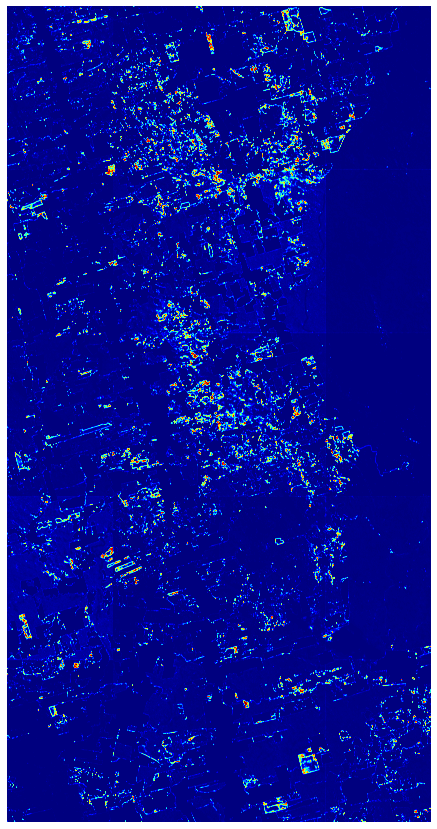

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
# show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
#plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
 #   dpi=150, bbox_inches='tight')

In [ ]:
ic(pred_entropy.shape)


ic| pred_entropy.shape: (17760, 9216)


(17760, 9216)

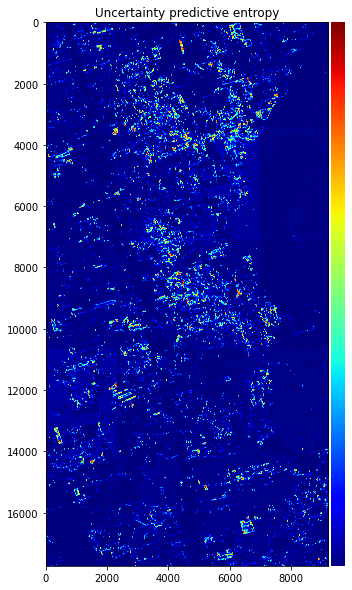

In [ ]:

# pred_entropy_to_show = pred_entropy[:label_mask.shape[0], :label_mask.shape[1]].copy()

# ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))

# pred_entropy_to_show[label_mask == 2] = 0
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
    dpi=150, bbox_inches='tight')

In [ ]:
ic(prob_rec.shape)
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))


ic| prob_rec.shape: (10, 17760, 9216, 1)
ic| np.min(prob_rec): 0.0
    np.mean(prob_rec): 0.0146207
    np.max(prob_rec): 1.0


(0.0, 0.0146207, 1.0)

In [ ]:

pred_entropy_single = single_experiment_entropy(prob_rec[0])

'''
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')
'''


ic| pred_entropy.shape: (17760, 9216)


"\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')\n"

In [ ]:

'''
MI = mutual_information(prob_rec)

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(MI, ax, title = 'Uncertainty MI')
'''


"\nMI = mutual_information(prob_rec)\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(MI, ax, title = 'Uncertainty MI')\n"

(array([0, 1, 2], dtype=uint8), array([81558000, 65246400, 16311600], dtype=int64))


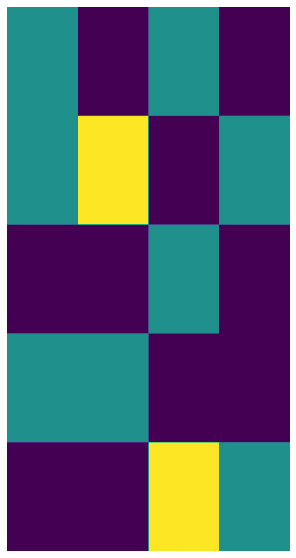

In [ ]:
# mask_tr_val = test 0, train 1, val 2. 
# mask_ts = test 1.
print(np.unique(mask_tr_val, return_counts=True))
plt.figure(figsize=(10,10))
plt.imshow(mask_tr_val)
plt.axis('off')
plt.savefig('figures/Train val mask.png', dpi=200, bbox_inches='tight')



In [ ]:
label_mask_current_deforestation = label_mask.copy()
label_mask_current_deforestation[label_mask_current_deforestation==2] = 0

In [ ]:
label_mask_current_deforestation_to_show = label_mask_current_deforestation.copy()
label_mask_current_deforestation_to_show = np.abs(
        label_mask_current_deforestation_to_show - 1)
ic(np.unique(label_mask_current_deforestation_to_show, return_counts=True))

ic| np.unique(label_mask_current_deforestation_to_show, return_counts=True): (array([  0, 255], dtype=uint8), array([  1838508, 161277492], dtype=int64))


(array([  0, 255], dtype=uint8), array([  1838508, 161277492], dtype=int64))

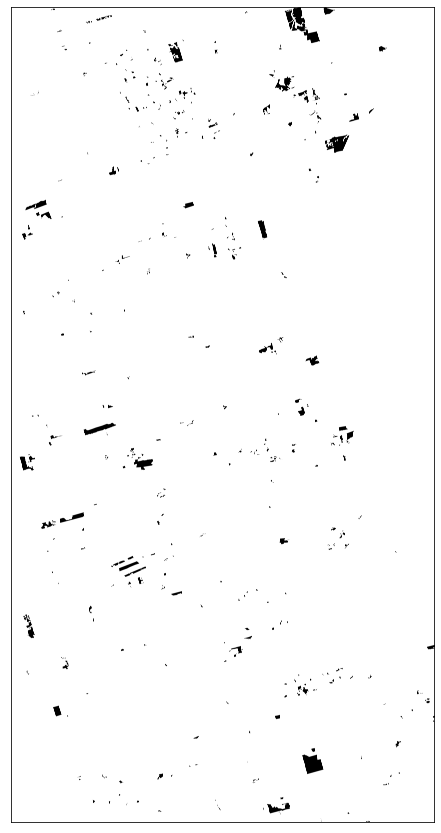

In [ ]:
# Computing error mask
# label_mask

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(label_mask_current_deforestation_to_show, cmap = plt.cm.gray)
fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')




In [ ]:


label_mask_val = label_mask[mask_tr_val == 2]
ic(label_mask_val.shape)

mean_prob_val = mean_prob[mask_tr_val == 2]

mean_prob_val = mean_prob_val[label_mask_val != 2]
label_mask_val_valid = label_mask_val[label_mask_val != 2]
ic(label_mask_val_valid.shape)



ic| label_mask_val.shape: (16311600,)
ic| label_mask_val_valid.shape: (9450701,)


(9450701,)

In [ ]:
from sklearn import metrics
pos_label = 1
precision, recall, thresholds = metrics.precision_recall_curve(
            label_mask_val_valid, mean_prob_val, pos_label=pos_label)



In [ ]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.496311, F-Score=0.805


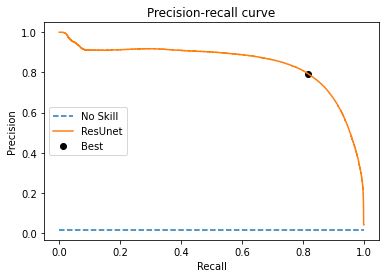

In [ ]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(label_mask_val, precision, recall, ix)
plt.savefig('figures/' + 'Para_prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [ ]:
print(mean_prob.shape)
predicted = np.zeros_like(mean_prob)
threshold = 0.5
# threshold = 0.698

predicted[mean_prob>=threshold] = 1
predicted[mean_prob<threshold] = 0
# predicted[prob_rec[0][...,-1][:label_mask.shape[0], :label_mask.shape[1]]>=threshold] = 1
# predicted[prob_rec[0][...,-1][:label_mask.shape[0], :label_mask.shape[1]]<threshold] = 0

print(np.unique(predicted, return_counts=True))

predicted_unpad = predicted.copy()
predicted_unpad[label_mask == 2] = 0
ic(predicted_unpad.shape, predicted.shape)
del predicted

(17730, 9200)
(array([0., 1.], dtype=float32), array([161471602,   1644398], dtype=int64))


ic| predicted_unpad.shape: (17730, 9200)
    predicted.shape: (17730, 9200)


In [ ]:
threshold

0.5

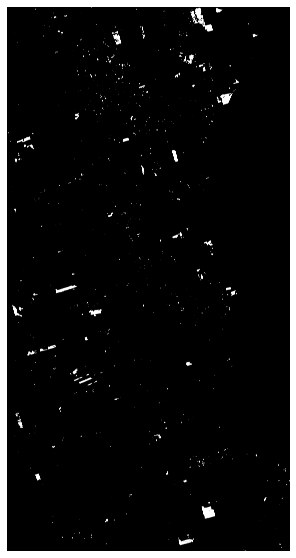

In [ ]:

plt.figure(figsize=(10,10))
plt.imshow(predicted_unpad, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' predicted.png', dpi=150, bbox_inches='tight')


In [ ]:

# mean_prob_unpad = mean_prob[:-npad[0][1], :-npad[1][1]]

In [ ]:
# mean_prob_unpad.shape

In [ ]:
# ic(mask_amazon_ts.shape)
# mask_amazon_ts = mask_amazon_ts[:-npad[0][1], :-npad[1][1]]


In [ ]:
# ic(mask_amazon_ts.shape, predicted_unpad.shape)
# label_mask_current_deforestation = label_mask_current_deforestation[:-npad[0][1], :-npad[1][1]]

In [ ]:
# label_mask = label_mask[:-npad[0][1], :-npad[1][1]]

In [ ]:
import importlib
import utils_v1
importlib.reload(utils_v1)

<module 'utils_v1' from 'd:\\Jorge\\deforestation_uncertainty\\utils_v1.py'>

In [ ]:
ic(predicted_unpad.shape, label_mask_current_deforestation.shape,
    mask_amazon_ts.shape, label_mask.shape, mean_prob.shape)

ic| predicted_unpad.shape: (17730, 9200)
    label_mask_current_deforestation.shape: (17730, 9200)
    mask_amazon_ts.shape: (17730, 9200)
    label_mask.shape: (17730, 9200)
    mean_prob.shape: (17730, 9200)


((17730, 9200), (17730, 9200), (17730, 9200), (17730, 9200), (17730, 9200))

In [ ]:
# test metrics
from sklearn.metrics import f1_score

predicted_test = predicted_unpad[mask_amazon_ts == 1]
label_mask_current_deforestation_test = label_mask_current_deforestation[mask_amazon_ts == 1]
label_mask_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]

ic(predicted_test.shape)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        predicted_test, label_mask_test)
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        label_mask_current_deforestation_test, label_mask_test)
mean_prob_test = utils_v1.excludeBackgroundAreasFromTest(
        mean_prob_test, label_mask_test)

ic(predicted_test.shape)


ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)


(54236371,)

In [ ]:
importlib.reload(_metrics)
removePolygons = True
if removePolygons == True:
    # remove polygons smaller than 625 px
    min_polygon_area = 625 # pixels

    predicted_unpad, label_mask = _metrics.removeSmallPolygonsForMetrics(predicted_unpad, label_mask,
        min_polygon_area)
    predicted_masked, label_masked = _metrics.getTest(predicted_unpad, label_mask, mask_amazon_ts)

    predicted_test = predicted_masked
    label_mask_current_deforestation_test = label_masked


ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161471602,   1644398], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161636922,   1479078], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([162950680,    165320], dtype=int64))
ic| predicted.shape: (17730, 9200), label_mask.shape: (17730, 9200)
ic| predicted_masked.shape: (81558000,)
    label_masked.shape: (81558000,)
ic| np.unique(label_masked, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                  array([53418216,   740517, 27399267], dtype=int64))
ic| predicted_masked.shape: (54158733,)
    label_masked.shape: (54158733,)


In [ ]:

deforestationMetricsGet = True
if deforestationMetricsGet == True:
        f1 = round(f1_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        precision = round(precision_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        recall = round(recall_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        if removePolygons == False:
                mAP = round(metrics.average_precision_score(label_mask_current_deforestation_test, 
                        mean_prob_test)*100, 2)
        else:
                '''
                # Computing metrics over the test tiles
                # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
                ref1 = np.ones_like(label_mask).astype(np.float32)

                ref1 [label_mask == 2] = 0
                TileMask = mask_amazon_ts * ref1
                GTTruePositives = label_mask==1

                # Metrics for th=0.5    

                Npoints = 50
                Pmax = np.max(mean_prob[GTTruePositives * TileMask ==1])
                ProbList = np.linspace(Pmax,0,Npoints)

                metrics_ = matrics_AA_recall(ProbList, mean_prob, label_mask, mask_amazon_ts, 625)
                print('Metrics th = 0.5: ', metrics_*100)
                '''
                pass


In [ ]:
ic(f1, precision, recall)
# ic(f1, precision, recall)


ic| f1: 81.01, precision: 91.73, recall: 72.53


(81.01, 91.73, 72.53)

### Metrics for validation set in forest/deforestation detection

In [ ]:
ic(mask_tr_val.shape)

ic| mask_tr_val.shape: (17730, 9200)


(17730, 9200)

In [ ]:
predicted_val = predicted_unpad[mask_tr_val == 2]
predicted_val = predicted_val[label_mask_val != 2]

In [ ]:

f1_val = round(f1_score(label_mask_val_valid, predicted_val)*100, 2)
precision_val = round(precision_score(label_mask_val_valid, predicted_val)*100, 2)
recall_val = round(recall_score(label_mask_val_valid, predicted_val)*100, 2)

mAP_val = round(metrics.average_precision_score(label_mask_val_valid, mean_prob_val)*100, 2)


ic(f1_val, precision_val, recall_val, mAP_val)

ic| f1_val: 81.47
    precision_val: 83.13
    recall_val: 79.87
    mAP_val: 84.63


(81.47, 83.13, 79.87, 84.63)

In [ ]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    # Computing metrics over the test tiles
    # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
    ref1 = np.ones_like(label_mask).astype(np.uint8)

    ref1 [label_mask == 2] = 0
    TileMask = mask_amazon_ts * ref1
    GTTruePositives = label_mask==1

    # Metrics for th=0.5    

    ProbList_05 = [0.5]

    metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
    print('Metrics th = 0.5: ', metrics_05*100)


In [ ]:

error_mask = np.abs(predicted_unpad - label_mask_current_deforestation)
print(np.unique(error_mask, return_counts=True))


(array([0., 1.], dtype=float32), array([162417462,    698538], dtype=int64))


In [ ]:
false_positive_mask = predicted_unpad - label_mask_current_deforestation
ic(false_positive_mask.shape)
ic(np.unique(false_positive_mask, return_counts=True))
# 0 class 0, 1 class 1, 2 false positive, 3 false negative
# colormap black, white, blue, red.



ic| false_positive_mask.shape: (17730, 9200)
ic| np.unique(false_positive_mask, return_counts=True): (array([-1.,  0.,  1.], dtype=float32),
                                                         array([   528984, 162417462,    169554], dtype=int64))


(array([-1.,  0.,  1.], dtype=float32),
 array([   528984, 162417462,    169554], dtype=int64))

In [ ]:
ic(predicted_unpad.shape, label_mask.shape)

ic| predicted_unpad.shape: (17730, 9200)
    label_mask.shape: (17730, 9200)


((17730, 9200), (17730, 9200))

In [ ]:

importlib.reload(_metrics)

prediced_unpad_to_show = predicted_unpad.copy()
prediced_unpad_to_show[label_mask == 2] = 0

error_mask_to_show = _metrics.getRgbErrorMask(prediced_unpad_to_show, 
        label_mask_current_deforestation).astype(np.uint8)
error_mask_to_show_rgb = _metrics.saveRgbErrorMask(error_mask_to_show).astype(np.uint8)
del error_mask_to_show
cv2.imwrite('figures/Para_error_mask_to_show_rgb.png', error_mask_to_show_rgb)

# ,
#        dim = (617, 1162)


True

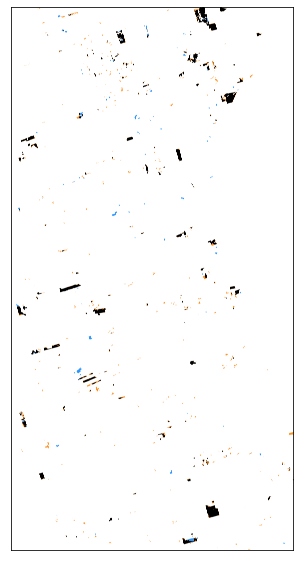

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])

ax.imshow(error_mask_to_show_rgb[...,::-1])

fig.savefig('figures/Para' + title_name + ' error mask color.png', dpi=300, bbox_inches='tight')


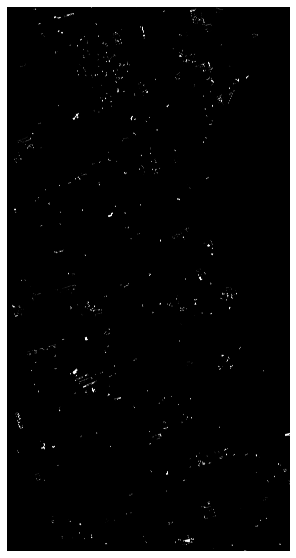

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(error_mask, cmap=plt.cm.gray)
title_name = 'ResUnet'
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [ ]:
ic(label_mask.shape)
ic(mask_amazon_ts.shape)
 
label_mask_test = utils_v1.getTestVectorFromIm(
        label_mask, mask_amazon_ts)        
ic(label_mask_test.shape)

error_mask_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_amazon_ts),
        label_mask_test) 


error_mask_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_tr_val, mask_return_value = 2),
        label_mask_val) 

 
ic(error_mask_test.shape)

ic| label_mask.shape: (17730, 9200)
ic| mask_amazon_ts.shape: (17730, 9200)
ic| label_mask_test.shape: (81558000,)
ic| error_mask_test.shape: (54158733,)


(54158733,)

In [ ]:
# ic(pred_entropy[:-npad[0][1], :-npad[1][1]][:-npad[0][1], :-npad[1][1]].shape)

In [ ]:
     

ic(pred_entropy.shape, utils_v1.unpadIm(pred_entropy, npad).shape, 
    mask_amazon_ts.shape, label_mask_test.shape)
pred_entropy_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_amazon_ts),
        label_mask_test)
  

ic| pred_entropy.shape: (17760, 9216)
    utils_v1.unpadIm(pred_entropy, npad).shape: (17730, 9200)
    mask_amazon_ts.shape: (17730, 9200)
    label_mask_test.shape: (81558000,)


In [ ]:
pred_entropy_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

In [ ]:
pred_entropy_single_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy_single, npad), mask_amazon_ts),
        label_mask_test)

pred_entropy_single_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy_single, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

In [ ]:
# dataset.previewLims1 = np.array([2200, 3200, 6900, 7900])
# dataset.previewLims2 = np.array([500, 1500, 3500, 4500])
# dataset.previewBands = [2, 1, 0] 

In [ ]:


# dataset.previewLims1 = np.array([7600, 8600, 4500, 5500])
# dataset.previewLims1 = np.array([12200, 13200, 200, 1200])
# dataset.previewLims1 = np.array([11800, 12800, 9000, 10000])

# dataset.previewLims1 = np.array([11500, 12500, 9000, 10000])

# dataset.previewLims2 = np.array([5000, 6000, 9500, 10500])

ic(dataset.previewLims1, dataset.previewLims2)
lims = dataset.previewLims1
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))
lims = dataset.previewLims2
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
ic(mask_amazon_ts.shape)


ic| dataset.previewLims1: array([2200, 3200, 6900, 7900])
    dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| mask_amazon_ts.shape: (17730, 9200)


(17730, 9200)

ic| dataset.previewLims1: array([2200, 3200, 6900, 7900])
    dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


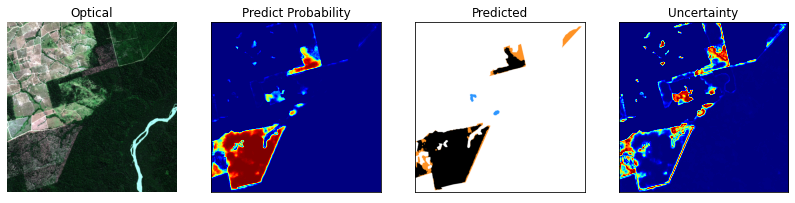

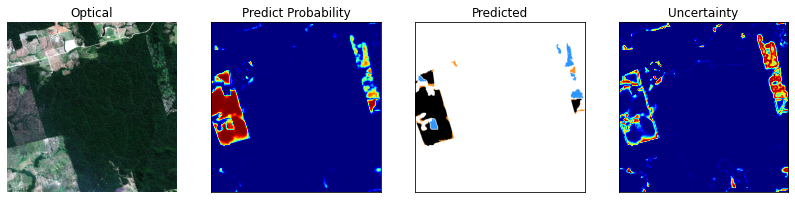

In [ ]:


plotCropSampleFlag = True
if plotCropSampleFlag == True:
        importlib.reload(_metrics)
        # import matplotlib
        # customCmap = matplotlib.colors.ListedColormap(['black', 'red'])
        ic(dataset.previewLims1, dataset.previewLims2)
        lims = dataset.previewLims1
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
        lims = dataset.previewLims2
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims1, 
                titles = ['Optical', 'Predict Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False])
        plt.savefig('figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty1.png', dpi=150, bbox_inches='tight')

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims2, 
                titles = ['Optical', 'Predict Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False])
        plt.savefig('figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty2.png', dpi=150, bbox_inches='tight')

In [ ]:
from enum import Enum
Predictor = Enum('Predictor', 'pred_var MI pred_entropy pred_entropy_single')
predictor = Predictor.pred_entropy
# predictor = Predictor.pred_var
# predictor = Predictor.pred_entropy_single
# predictor = Predictor.MI

if predictor == Predictor.pred_var:
    uncertainty = pred_var_test
    uncertainty_val = pred_var_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Variance'
    best_threshold = 0.2
elif predictor == Predictor.MI:
    uncertainty = MI_test
    uncertainty_val = MI_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Mutual Information'
    best_threshold = 0.2
elif predictor == Predictor.pred_entropy:
    uncertainty = pred_entropy_test
    uncertainty_val = pred_entropy_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy'
    best_threshold = 0.287
elif predictor == Predictor.pred_entropy_single:
    uncertainty = pred_entropy_single_test
    uncertainty_val = pred_entropy_single_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy Single'
    best_threshold = 0.287


In [ ]:
ic(np.min(uncertainty), np.mean(uncertainty), np.max(uncertainty))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))


ic| np.min(uncertainty): 7.492461e-13
    np.mean(uncertainty): 0.017911673
    np.max(uncertainty): 0.36787948
ic| np.min(pred_entropy): 2.239831e-22
    np.mean(pred_entropy): 0.014229346
    np.max(pred_entropy): 0.36787948


(2.239831e-22, 0.014229346, 0.36787948)

In [ ]:

y_test = error_mask_test
y_val = error_mask_val

ic(y_test.shape, uncertainty.shape)
pos_label = 1
ROCmode = 'val'
if ROCmode == 'test':
    fpr, tpr, thresholds = metrics.roc_curve(y_test, uncertainty, pos_label=pos_label)
elif ROCmode == 'val':
    fpr, tpr, thresholds = metrics.roc_curve(y_val, uncertainty_val, pos_label=pos_label)

roc_auc = metrics.auc(fpr, tpr)
ic(roc_auc)

ic| y_test.shape: (54158733,), uncertainty.shape: (54158733,)
ic| roc_auc: 0.9316776418769617


0.9316776418769617

Best Threshold=0.048247, G-Mean=0.888


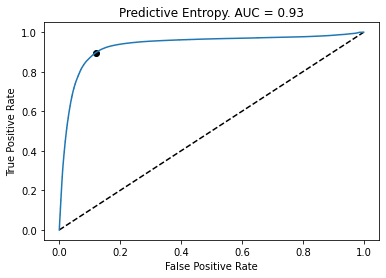

In [ ]:
importlib.reload(_metrics)
plt.figure()
_metrics.plotAUC(fpr, tpr, roc_auc, modelId = title_name)
ix, best_threshold_uncertainty = _metrics.getBestThresholdGMean(fpr, tpr, thresholds)
# ix, best_threshold_uncertainty = _metrics.getBestThresholdJStatistic(fpr, tpr, thresholds)

_metrics.plotBestThreshold(fpr, tpr, ix)
plt.savefig(figures_path + title_name + ' roc_curve.png', dpi=200)

In [ ]:
np.set_printoptions(suppress=False)
ic(best_threshold_uncertainty)
np.set_printoptions(suppress=True)


ic| best_threshold_uncertainty: 0.048247058


In [ ]:
# best_threshold_uncertainty = 0.262948
# best_threshold_uncertainty = 0.08329400420188904

In [ ]:
# threshold = 0.003254
y_pred_thresholded = np.zeros_like(uncertainty)
y_pred_thresholded[uncertainty >= best_threshold_uncertainty] = 1


In [ ]:
metrics_error_detection = False
if metrics_error_detection == True:
    f1 = round(f1_score(error_mask_test, y_pred_thresholded)*100, 2)
    precision = round(metrics.precision_score(error_mask_test, y_pred_thresholded)*100, 2)
    recall = round(metrics.recall_score(error_mask_test, y_pred_thresholded)*100, 2)
    ic(f1, precision, recall)

    cm = metrics.confusion_matrix(error_mask_test, y_pred_thresholded)
    print(cm)

In [ ]:
if metrics_error_detection == True:

    ic(best_threshold_uncertainty)

In [ ]:
if metrics_error_detection == True:

    predicted_error_mask = np.zeros(pred_entropy.shape, dtype = np.uint8)
    predicted_error_mask[pred_entropy>=best_threshold_uncertainty] = 1
    predicted_error_mask = utils_v1.unpadIm(predicted_error_mask, npad)

    predicted_error_mask[label_mask == 2] = 0

In [ ]:
if metrics_error_detection == True:

    # ic(np.unique(predicted_error_mask, return_counts=True))
    # ic(np.unique(error_mask, return_counts=True))
    predicted_error_mask_to_show = predicted_error_mask.copy()
    predicted_error_mask_to_show = np.abs(1 - predicted_error_mask_to_show)
    predicted_error_mask_to_show = predicted_error_mask_to_show.astype(np.uint8)*255
    predicted_error_mask_to_show = np.repeat(
        np.expand_dims(predicted_error_mask_to_show, axis=-1),
        3, axis = -1)
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(predicted_error_mask_to_show)


    title_name = 'ResUnet'
    fig.savefig('figures/Para' + title_name + 'predicted error mask.png', dpi=300, bbox_inches='tight')


In [ ]:
if metrics_error_detection == True:

    predicted_error_mask_forest = predicted_error_mask.copy()
    predicted_error_mask_forest[predicted_unpad == 1] = 0
    ic(np.unique(predicted_unpad, return_counts=True))
    ic(np.unique(predicted_error_mask_forest, return_counts=True))

    plt.figure(figsize=(10,10))
    plt.imshow(predicted_error_mask, cmap=plt.cm.gray)
    title_name = 'ResUnet'
    plt.axis('off')
    plt.savefig('figures/Para' + title_name + 'predicted error mask forest.png', dpi=150, bbox_inches='tight')


In [ ]:
if metrics_error_detection == True:

        importlib.reload(_metrics)
        _metrics.plotConfusionMatrix(cm)
        plt.savefig(figures_path + title_name + ' confusion matrix ROC threshold.png', 
                dpi=200, bbox_inches='tight')

In [ ]:
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                label_mask_current_deforestation, mask_amazon_ts),
        label_mask_test)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                predicted_unpad, mask_amazon_ts),
        label_mask_test)
        


Get precision-recall threshold

In [ ]:
precision, recall, thresholds = metrics.precision_recall_curve(
            y_val, uncertainty_val, pos_label=pos_label)



In [ ]:
ic(thresholds)

ic| thresholds: array([0.00033218, 0.00033219, 0.00033219, ..., 0.36787942, 0.36787945,
                       0.36787948], dtype=float32)


array([0.00033218, 0.00033219, 0.00033219, ..., 0.36787942, 0.36787945,
       0.36787948], dtype=float32)

In [ ]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold_uncertainty = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.314926, F-Score=0.271


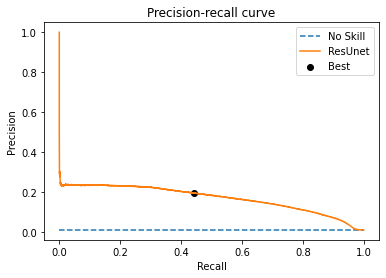

In [ ]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(y_val, precision, recall, ix)
plt.savefig('figures/' + 'Para' + 'prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [ ]:
'''
# Metrics for th=0.5    
ProbList_05 = [0.5]

metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
print('Metrics th = 0.5: ', metrics_05*100)
'''


"\n# Metrics for th=0.5    \nProbList_05 = [0.5]\n\nmetrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)\nprint('Metrics th = 0.5: ', metrics_05*100)\n"

In [ ]:
ic(np.min(uncertainty), np.average(uncertainty), np.max(uncertainty))

ic| np.min(uncertainty): 7.492461e-13
    np.average(uncertainty): 0.017911673
    np.max(uncertainty): 0.36787948


(7.492461e-13, 0.017911673, 0.36787948)

In [ ]:
# plt.hist(uncertainty)

In [ ]:
ic(uncertainty.dtype, label_mask_current_deforestation_test.dtype, predicted_test.dtype)

ic| uncertainty.dtype: dtype('float32')
    label_mask_current_deforestation_test.dtype: dtype('uint8')
    predicted_test.dtype: dtype('float32')


(dtype('float32'), dtype('uint8'), dtype('float32'))

In [ ]:
ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
ic(np.unique(label_mask_current_deforestation_test))

ic| uncertainty.shape: (54158733,)
    label_mask_current_deforestation_test.shape: (54158733,)
ic| np.unique(label_mask_current_deforestation_test): array([0, 1], dtype=uint8)


array([0, 1], dtype=uint8)

In [ ]:
ic(np.min(uncertainty), np.mean(uncertainty), np.max(uncertainty))

ic| np.min(uncertainty): 7.492461e-13
    np.mean(uncertainty): 0.017911673
    np.max(uncertainty): 0.36787948


(7.492461e-13, 0.017911673, 0.36787948)

In [ ]:
importlib.reload(_metrics)

threshold_uncertainty = 0.15

predicted_thresholded = np.zeros_like(uncertainty).astype(np.int8)
predicted_thresholded[uncertainty >= threshold_uncertainty] = 1
predicted_thresholded = predicted_thresholded.astype(np.uint8)
ic(predicted_thresholded.shape)


ic| predicted_thresholded.shape: (54158733,)


(54158733,)

In [ ]:
ic(np.unique(predicted_thresholded, return_counts=True),
    np.unique(label_mask, return_counts=True),
    np.unique(mask_amazon_ts, return_counts=True))



ic| np.unique(predicted_thresholded, return_counts=True): (array([0, 1], dtype=uint8), array([52036112,  2122621], dtype=int64))
    np.unique(label_mask, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                array([100794101,   1782685,  60539214], dtype=int64))
    np.unique(mask_amazon_ts, return_counts=True): (array([0, 1], dtype=uint8), array([81558000, 81558000], dtype=int64))


((array([0, 1], dtype=uint8), array([52036112,  2122621], dtype=int64)),
 (array([0, 1, 2], dtype=uint8),
  array([100794101,   1782685,  60539214], dtype=int64)),
 (array([0, 1], dtype=uint8), array([81558000, 81558000], dtype=int64)))

In [ ]:
def getUncertaintyPercentageFromTest(uncertainty_mask, 
        label_mask, mask_test):
    total_test_area = mask_test.copy()
    total_test_area[label_mask == 2] = 0

    percentage = np.count_nonzero(uncertainty_mask.flatten()) / np.count_nonzero(total_test_area.flatten())
    return total_test_area, percentage

total_test_area, percentage = getUncertaintyPercentageFromTest(predicted_thresholded, 
        label_mask, mask_amazon_ts)

ic(percentage)

ic| percentage: 0.03919258967893507


0.03919258967893507

In [ ]:
AA = np.count_nonzero(predicted_thresholded.flatten()) / len(label_mask_current_deforestation_test)
ic(AA)

# metrics_values = _metrics.getAA_Recall(uncertainty, 
#                 label_mask_current_deforestation_test, 
#                 predicted_test, [threshold_uncertainty])


ic| AA: 0.03919258967893507


0.03919258967893507

In [ ]:

importlib.reload(_metrics)

# threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

# threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003]
threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
        0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]

loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metrics_values = _metrics.getAA_Recall(uncertainty, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        # ic(metrics_values)


ic| uncertainty.shape: (54158733,)
    label_mask_current_deforestation_test.shape: (54158733,)


threshold 0.0025
(30694127,) (30694127,)


ic| label_current_deforestation_test_classified_incorrect.shape: (23464606,)
    predicted_test_classified_incorrect.shape: (23464606,)


cm_correct [[30613759        0]
 [    1153    79215]]


ic| TP_H + FN_H + FP_H + TN_H: 23464606
    len(label_mask_current_deforestation_test): 54158733
ic| TP_H + FN_H + FP_H + TN_H: 23464606
    len(label_mask_current_deforestation_test): 54158733


cm_incorrect [[22756031    48426]
 [  202253   457896]]
[1.         0.98565349 0.10697256 0.43325618 0.90435731 0.69362523]
threshold 0.005
(39333508,) (39333508,)


ic| label_current_deforestation_test_classified_incorrect.shape: (14825225,)
    predicted_test_classified_incorrect.shape: (14825225,)


cm_correct [[39214335        0]
 [    3286   115887]]


ic| TP_H + FN_H + FP_H + TN_H: 14825225
    len(label_mask_current_deforestation_test): 54158733
ic| TP_H + FN_H + FP_H + TN_H: 14825225
    len(label_mask_current_deforestation_test): 54158733


cm_incorrect [[14155455    48426]
 [  200120   421224]]
[1.         0.97242664 0.15649472 0.27373656 0.89688917 0.67792398]
threshold 0.0075
(42364894,) (42364894,)


ic| label_current_deforestation_test_classified_incorrect.shape: (11793839,)
    predicted_test_classified_incorrect.shape: (11793839,)


cm_correct [[42218920        0]
 [    4647   141327]]


ic| TP_H + FN_H + FP_H + TN_H: 11793839
    len(label_mask_current_deforestation_test): 54158733
ic| TP_H + FN_H + FP_H + TN_H: 11793839
    len(label_mask_current_deforestation_test): 54158733


cm_incorrect [[11150870    48426]
 [  198759   395784]]
[1.         0.96816556 0.1908491  0.21776431 0.89098399 0.66569449]
threshold 0.01
(44324500,) (44324500,)


ic| label_current_deforestation_test_classified_incorrect.shape: (9834233,)
    predicted_test_classified_incorrect.shape: (9834233,)


cm_correct [[44160279        0]
 [    5588   158633]]


ic| TP_H + FN_H + FP_H + TN_H: 9834233
    len(label_mask_current_deforestation_test): 54158733
ic| TP_H + FN_H + FP_H + TN_H: 9834233
    len(label_mask_current_deforestation_test): 54158733


cm_incorrect [[9209511   48426]
 [ 197818  378478]]
[1.         0.96597268 0.21421925 0.18158167 0.88656466 0.65674237]
threshold 0.015
(46577089,) (46577089,)


ic| label_current_deforestation_test_classified_incorrect.shape: (7581644,)
    predicted_test_classified_incorrect.shape: (7581644,)


cm_correct [[46385917       37]
 [    6819   184316]]


ic| TP_H + FN_H + FP_H + TN_H: 7581644
    len(label_mask_current_deforestation_test): 54158733
ic| TP_H + FN_H + FP_H + TN_H: 7581644
    len(label_mask_current_deforestation_test): 54158733


cm_incorrect [[6983873   48389]
 [ 196587  352795]]
[0.9997993  0.96432365 0.24890178 0.13998932 0.87938452 0.64216702]
threshold 0.025
(48272459,) (48272459,)


ic| label_current_deforestation_test_classified_incorrect.shape: (5886274,)
    predicted_test_classified_incorrect.shape: (5886274,)


cm_correct [[48045566      479]
 [    8553   217861]]


ic| TP_H + FN_H + FP_H + TN_H: 5886274
    len(label_mask_current_deforestation_test): 54158733
ic| TP_H + FN_H + FP_H + TN_H: 5886274
    len(label_mask_current_deforestation_test): 54158733


cm_incorrect [[5324224   47947]
 [ 194853  319250]]
[0.99780617 0.96222407 0.29420121 0.10868559 0.86942431 0.62098451]
threshold 0.05
(49948434,) (49948434,)


ic| label_current_deforestation_test_classified_incorrect.shape: (4210299,)
    predicted_test_classified_incorrect.shape: (4210299,)


cm_correct [[49664127     2241]
 [   12543   269523]]


ic| TP_H + FN_H + FP_H + TN_H: 4210299
    len(label_mask_current_deforestation_test): 54158733
ic| TP_H + FN_H + FP_H + TN_H: 4210299
    len(label_mask_current_deforestation_test): 54158733


cm_incorrect [[3705663   46185]
 [ 190863  267588]]
[0.99175387 0.95553168 0.36396599 0.07773998 0.8528076  0.58367852]
threshold 0.08
(50899788,) (50899788,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3258945,)
    predicted_test_classified_incorrect.shape: (3258945,)


cm_correct [[50566481     3778]
 [   17758   311771]]


ic| TP_H + FN_H + FP_H + TN_H: 3258945
    len(label_mask_current_deforestation_test): 54158733
ic| TP_H + FN_H + FP_H + TN_H: 3258945
    len(label_mask_current_deforestation_test): 54158733


cm_incorrect [[2803309   44648]
 [ 185648  225340]]
[0.98802722 0.94611096 0.42101802 0.06017395 0.83462969 0.54828851]
threshold 0.1
(51314555,) (51314555,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2844178,)
    predicted_test_classified_incorrect.shape: (2844178,)


cm_correct [[50953503     4927]
 [   21366   334759]]


ic| TP_H + FN_H + FP_H + TN_H: 2844178
    len(label_mask_current_deforestation_test): 54158733
ic| TP_H + FN_H + FP_H + TN_H: 2844178
    len(label_mask_current_deforestation_test): 54158733


cm_incorrect [[2416287   43499]
 [ 182040  202352]]
[0.98549543 0.94000421 0.4520612  0.05251559 0.82306763 0.52642095]
threshold 0.15
(52036112,) (52036112,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2122621,)
    predicted_test_classified_incorrect.shape: (2122621,)


cm_correct [[51615256     8914]
 [   31026   380916]]


ic| TP_H + FN_H + FP_H + TN_H: 2122621
    len(label_mask_current_deforestation_test): 54158733
ic| TP_H + FN_H + FP_H + TN_H: 2122621
    len(label_mask_current_deforestation_test): 54158733


cm_incorrect [[1754534   39512]
 [ 172380  156195]]
[0.97713362 0.92468357 0.51439197 0.03919259 0.79810635 0.47537092]
threshold 0.2
(52540904,) (52540904,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1617829,)
    predicted_test_classified_incorrect.shape: (1617829,)
ic

cm_correct [[52065381    14549]
 [   41867   419107]]
cm_incorrect [[1304409   33877]
 [ 161539  118004]]


| TP_H + FN_H + FP_H + TN_H: 1617829
    len(label_mask_current_deforestation_test): 54158733
ic| TP_H + FN_H + FP_H + TN_H: 1617829
    len(label_mask_current_deforestation_test): 54158733


[0.96645037 0.90917709 0.5659654  0.02987199 0.77695038 0.42213184]
threshold 0.225
(52754041,) (52754041,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1404692,)
    predicted_test_classified_incorrect.shape: (1404692,)
ic| TP_H + FN_H + FP_H + TN_H: 1404692
    len(label_mask_current_deforestation_test): 54158733
ic| TP_H 

cm_correct [[52249748    18112]
 [   47812   438369]]
cm_incorrect [[1120042   30314]
 [ 155594   98742]]


+ FN_H + FP_H + TN_H: 1404692
    len(label_mask_current_deforestation_test): 54158733


[0.96032255 0.90165802 0.59197696 0.02593657 0.76510972 0.38823446]
threshold 0.25
(52952948,) (52952948,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1205785,)
    predicted_test_classified_incorrect.shape: (1205785,)
ic| TP_H + FN_H + FP_H + TN_H: 1205785
    len(label_mask_current_deforestation_test): 54158733
ic| TP_H + FN_H + FP_H + TN_H: 1205785
    len(label_mask_current_deforestation_test): 54158733


cm_correct [[52418645    22115]
 [   54713   457475]]
cm_incorrect [[951145  26311]
 [148693  79636]]
[0.9538877  0.8931779  0.61777785 0.02226391 0.75165885 0.34877742]
threshold 0.27
(53104850,) (53104850,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1053883,)
    predicted_test_classified_incorrect.shape: (1053883,)
ic| TP_H + FN_H + FP_H + TN_H: 1053883
    len(label_mask_current_deforestation_test): 54158733
ic| TP_H + FN_H + FP_H + TN_H: 1053883
    len(label_mask_current_deforestation_test): 54158733


cm_correct [[52545219    25859]
 [   60864   472908]]
cm_incorrect [[824571  22567]
 [142542  64203]]
[0.94815415 0.88597379 0.63861869 0.01945915 0.73992163 0.31054197]
threshold 0.3
(53332508,) (53332508,)


ic| label_current_deforestation_test_classified_incorrect.shape: (826225,)
    predicted_test_classified_incorrect.shape: (826225,)
ic| TP_H + FN_H + FP_H + TN_H: 826225
    len(label_mask_current_deforestation_test): 54158733
ic| TP_H + FN_H + FP_H + TN_H: 826225
    len(label_mask_current_deforestation_test): 54158733


cm_correct [[52730722    32809]
 [   72496   496481]]
cm_incorrect [[639068  15617]
 [130910  40630]]
[0.93801319 0.87258536 0.67045186 0.01525562 0.72234964 0.23685438]
threshold 0.34
(53661198,) (53661198,)


ic| label_current_deforestation_test_classified_incorrect.shape: (497535,)
    predicted_test_classified_incorrect.shape: (497535,)
ic| TP_H + FN_H + FP_H + TN_H: 497535
    len(label_mask_current_deforestation_test): 54158733
ic| TP_H + FN_H + FP_H + TN_H: 497535
    len(label_mask_current_deforestation_test): 54158733


cm_correct [[52988296    45781]
 [   96227   530894]]
cm_incorrect [[381494   2645]
 [107179   6217]]
[0.92061213 0.84655752 0.71692345 0.00918661 0.70153464 0.05482557]
threshold 0.36
(53907440,) (53907440,)


ic| label_current_deforestation_test_classified_incorrect.shape: (251293,)
    predicted_test_classified_incorrect.shape: (251293,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:286: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 251293
    len(label_mask_current_deforestation_test): 54158733
ic| TP_H + FN_H + FP_H + TN_H: 251293
    len(label_mask_current_deforestation_test): 54158733


cm_correct [[53179524    48426]
 [  142379   537111]]
cm_incorrect [[190266      0]
 [ 61027      0]]
[0.91729643 0.79046196 0.72531893 0.00463993        nan 0.        ]
threshold 0.3648794801235199
(54007427,) (54007427,)


ic| label_current_deforestation_test_classified_incorrect.shape: (151306,)
    predicted_test_classified_incorrect.shape: (151306,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:286: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 151306
    len(label_mask_current_deforestation_test): 54158733
ic| TP_H + FN_H + FP_H + TN_H: 151306
    len(label_mask_current_deforestation_test): 54158733


cm_correct [[53255466    48426]
 [  166424   537111]]
cm_incorrect [[114324      0]
 [ 36982      0]]
[0.91729643 0.76344603 0.72531893 0.00279375        nan 0.        ]
threshold 0.3663794801235199
(54052306,) (54052306,)


ic| label_current_deforestation_test_classified_incorrect.shape: (106427,)
    predicted_test_classified_incorrect.shape: (106427,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:286: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 106427
    len(label_mask_current_deforestation_test): 54158733
ic| TP_H + FN_H + FP_H + TN_H: 106427
    len(label_mask_current_deforestation_test): 54158733


cm_correct [[53289431    48426]
 [  177338   537111]]
cm_incorrect [[80359     0]
 [26068     0]]
[0.91729643 0.75178354 0.72531893 0.00196509        nan 0.        ]


In [ ]:

if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metric_values_audited = _metrics.getUncertaintyMetricsAudited(uncertainty, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        ic(metric_values_audited)



ic| uncertainty.shape: (54158733,)
    label_mask_current_deforestation_test.shape: (54158733,)


threshold 0.0025
(54158733,) (54158733,)
cm_audited [[53418216        0]
 [    1153   739364]]
[1.         0.99844298]
threshold 0.005
(54158733,) (54158733,)
cm_audited [[53418216        0]
 [    3286   737231]]
[1.         0.99556256]
threshold 0.0075
(54158733,) (54158733,)
cm_audited [[53418216        0]
 [    4647   735870]]
[1.         0.99372465]
threshold 0.01
(54158733,) (54158733,)
cm_audited [[53418216        0]
 [    5588   734929]]
[1.         0.99245392]
threshold 0.015
(54158733,) (54158733,)
cm_audited [[53418179       37]
 [    6819   733698]]
[0.99994957 0.99079157]
threshold 0.025
(54158733,) (54158733,)
cm_audited [[53417737      479]
 [    8553   731964]]
[0.99934602 0.98844996]
threshold 0.05
(54158733,) (54158733,)
cm_audited [[53415975     2241]
 [   12543   727974]]
[0.99693104 0.98306183]
threshold 0.08
(54158733,) (54158733,)
cm_audited [[53414438     3778]
 [   17758   722759]]
[0.99479999 0.97601946]
threshold 0.1
(54158733,) (54158733,)
cm_audited [[534132

ic| metric_values_audited: array([[1.        , 0.99844298],
                                  [1.        , 0.99556256],
                                  [1.        , 0.99372465],
                                  [1.        , 0.99245392],
                                  [0.99994957, 0.99079157],
                                  [0.99934602, 0.98844996],
                                  [0.99693104, 0.98306183],
                                  [0.99479999, 0.97601946],
                                  [0.99319548, 0.97114719],
                                  [0.98759196, 0.95810224],
                                  [0.97960036, 0.94346247],
                                  [0.97451946, 0.9354343 ],
                                  [0.96876055, 0.92611513],
                                  [0.96334719, 0.91780877],
                                  [0.95318551, 0.90210083],
                                  [0.93365755, 0.8700543 ],
                                  [0.925

cm_audited [[53369790    48426]
 [  177338   563179]]
[0.92082145 0.76052137]


In [ ]:
m_audited = {'precision': metric_values_audited[:,0],
        'recall': metric_values_audited[:,1]}



In [ ]:
'''
threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]
importlib.reload(_metrics)

metrics = _metrics.getF1byThreshold(uncertainty,
    error_mask, threshold_list)

ic(metrics)
'''

'\nthreshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]\nimportlib.reload(_metrics)\n\nmetrics = _metrics.getF1byThreshold(uncertainty,\n    error_mask, threshold_list)\n\nic(metrics)\n'

In [ ]:
if loadThresholdMetrics == False:

    np.save('metrics.npy', metrics_values)
if loadThresholdMetrics == True:
    metrics_values = np.load('metrics.npy')


In [ ]:
save_figures = True

In [ ]:
m = {'precision_L': metrics_values[:,0],
        'recall_L': metrics_values[:,1],
        'recall_Ltotal': metrics_values[:,2],
        'AA': metrics_values[:,3],
        'precision_H': metrics_values[:,4],
        'recall_H': metrics_values[:,5]}

m['f1_L'] = 2*m['precision_L']*m['recall_L']/(m['precision_L']+m['recall_L'])
m['f1_H'] = 2*m['precision_H']*m['recall_H']/(m['precision_H']+m['recall_H'])

m_audited['f1'] = 2*m_audited['precision']*m_audited['recall']/(m_audited['precision']+m_audited['recall'])

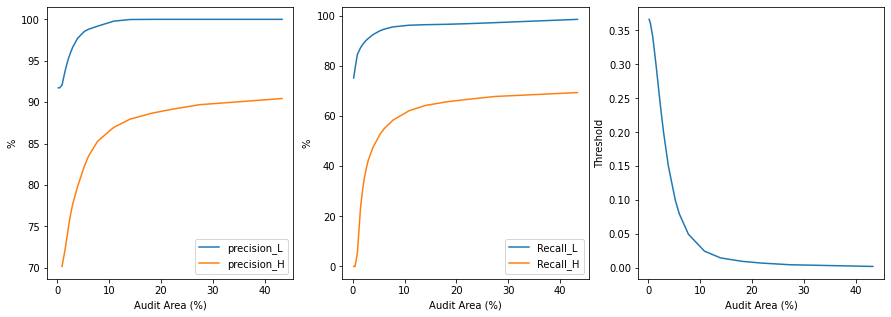

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, label="precision_L")
ax1.plot(m['AA']*100, m['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m['AA']*100, m['recall_L']*100, label="Recall_L")
ax2.plot(m['AA']*100, m['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA.png', dpi=150, bbox_inches='tight')

In [ ]:
xlim = [-0.3, 12.7]
xlim = [-0.1, 10.4]

ylim = [0, 105]


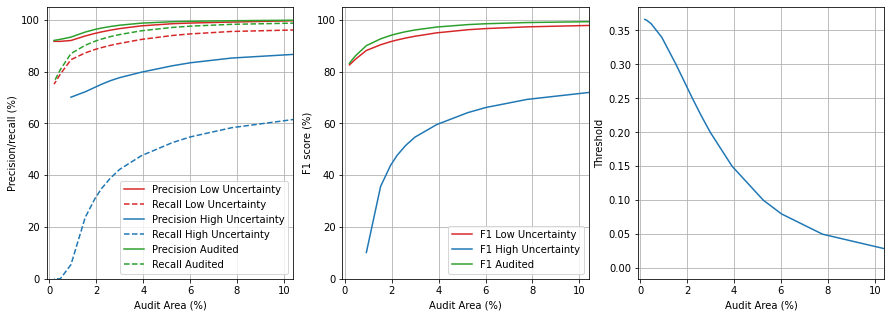

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, 'C3-', label="Precision Low Uncertainty")
ax1.plot(m['AA']*100, m['recall_L']*100, 'C3--', label="Recall Low Uncertainty")
ax1.plot(m['AA']*100, m['precision_H']*100, 'C0-', label="Precision High Uncertainty")
ax1.plot(m['AA']*100, m['recall_H']*100, 'C0--', label="Recall High Uncertainty")
ax1.plot(m['AA']*100, m_audited['precision']*100, 'C2-', label="Precision Audited")
ax1.plot(m['AA']*100, m_audited['recall']*100, 'C2--', label="Recall Audited")

ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.grid()
ax2.plot(m['AA']*100, m['f1_L']*100, 'C3-', label="F1 Low Uncertainty")
ax2.plot(m['AA']*100, m['f1_H']*100, 'C0-', label="F1 High Uncertainty")
ax2.plot(m['AA']*100, m_audited['f1']*100, 'C2-', label="F1 Audited")

ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax2.grid()
ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')
ax3.grid()
ax3.set_xlim(xlim)

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_f1_AA.png', dpi=150, bbox_inches='tight')

In [ ]:


m

{'precision_L': array([1.        , 1.        , 1.        , 1.        , 0.9997993 ,
        0.99780617, 0.99175387, 0.98802722, 0.98549543, 0.97713362,
        0.96645037, 0.96032255, 0.9538877 , 0.94815415, 0.93801319,
        0.92061213, 0.91729643, 0.91729643, 0.91729643]),
 'recall_L': array([0.98565349, 0.97242664, 0.96816556, 0.96597268, 0.96432365,
        0.96222407, 0.95553168, 0.94611096, 0.94000421, 0.92468357,
        0.90917709, 0.90165802, 0.8931779 , 0.88597379, 0.87258536,
        0.84655752, 0.79046196, 0.76344603, 0.75178354]),
 'recall_Ltotal': array([0.10697256, 0.15649472, 0.1908491 , 0.21421925, 0.24890178,
        0.29420121, 0.36396599, 0.42101802, 0.4520612 , 0.51439197,
        0.5659654 , 0.59197696, 0.61777785, 0.63861869, 0.67045186,
        0.71692345, 0.72531893, 0.72531893, 0.72531893]),
 'AA': array([0.43325618, 0.27373656, 0.21776431, 0.18158167, 0.13998932,
        0.10868559, 0.07773998, 0.06017395, 0.05251559, 0.03919259,
        0.02987199, 0.025936

In [ ]:
m_audited

{'precision': array([1.        , 1.        , 1.        , 1.        , 0.99994957,
        0.99934602, 0.99693104, 0.99479999, 0.99319548, 0.98759196,
        0.97960036, 0.97451946, 0.96876055, 0.96334719, 0.95318551,
        0.93365755, 0.92510254, 0.9222096 , 0.92082145]),
 'recall': array([0.99844298, 0.99556256, 0.99372465, 0.99245392, 0.99079157,
        0.98844996, 0.98306183, 0.97601946, 0.97114719, 0.95810224,
        0.94346247, 0.9354343 , 0.92611513, 0.91780877, 0.90210083,
        0.8700543 , 0.80773027, 0.77525972, 0.76052137]),
 'f1': array([0.99922088, 0.99777635, 0.99685245, 0.99621267, 0.99534951,
        0.99386813, 0.98994786, 0.98532024, 0.9820476 , 0.97262362,
        0.96119187, 0.95457696, 0.94695796, 0.94002679, 0.92693987,
        0.90073452, 0.86244134, 0.84237394, 0.83302986])}

In [ ]:
exp

99

In [ ]:

importlib.reload(_metrics)


# threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
#         0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
#threshold_list2 = [0.09] # exp 77 PA 50 runs
# threshold_list2 = [0.085] # exp 77 PA 30 runs
# threshold_list2 = [0.085] # exp 77 PA 10 runs
# threshold_list2 = [0.083] # exp 77 PA 5 runs
threshold_list2 = [0.065] # exp 77 PA 5 runs
threshold_list2 = [0.06] # exp 77 PA 5 runs
threshold_list2 = [0.0825] # exp 77 PA 3 runs

if exp == 90:
        threshold_list2 = [0.14]
elif exp == 91:
        threshold_list2 = [0.16]
elif exp == 92:
        threshold_list2 = [0.125]
elif exp == 93:
        threshold_list2 = [0.13]
elif exp == 94:
        threshold_list2 = [0.217]
elif exp == 95:
        threshold_list2 = [0.217]
elif exp == 96:
        threshold_list2 = [0.115]
elif exp == 97:
        threshold_list2 = [0.127]
elif exp == 98:
        threshold_list2 = [0.133]
elif exp == 99:
        threshold_list2 = [0.197]

ic(uncertainty.shape, label_mask_current_deforestation_test.shape)

metrics_values2 = _metrics.getAA_Recall(uncertainty, 
        label_mask_current_deforestation_test, 
        predicted_test, threshold_list2)

metric_values_audited2 = _metrics.getUncertaintyMetricsAudited(uncertainty, 
        label_mask_current_deforestation_test, 
        predicted_test, threshold_list2)



ic| uncertainty.shape: (54158733,)
    label_mask_current_deforestation_test.shape: (54158733,)


threshold 0.197
(52513959,) (52513959,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1644774,)
    predicted_test_classified_incorrect.shape: (1644774,)


cm_correct [[52041787    14160]
 [   41160   416852]]
cm_incorrect [[1328003   34266]
 [ 162246  120259]]


ic| TP_H + FN_H + FP_H + TN_H: 1644774
    len(label_mask_current_deforestation_test): 54158733
ic| TP_H + FN_H + FP_H + TN_H: 1644774
    len(label_mask_current_deforestation_test): 54158733


[0.96714709 0.91013336 0.56292023 0.03036951 0.77824947 0.42568804]
threshold 0.197
(54158733,) (54158733,)
cm_audited [[53404056    14160]
 [   41160   699357]]
[0.98015464 0.94441721]


In [ ]:
m2 = {'precision_L': metrics_values2[:,0],
        'recall_L': metrics_values2[:,1],
        'recall_Ltotal': metrics_values2[:,2],
        'AA': metrics_values2[:,3],
        'precision_H': metrics_values2[:,4],
        'recall_H': metrics_values2[:,5]}

m_audited2 = {'precision': metric_values_audited2[:,0],
        'recall': metric_values_audited2[:,1]}

m2['f1_L'] = 2*m2['precision_L']*m2['recall_L']/(m2['precision_L']+m2['recall_L'])
m2['f1_H'] = 2*m2['precision_H']*m2['recall_H']/(m2['precision_H']+m2['recall_H'])

m_audited2['f1'] = 2*m_audited2['precision']*m_audited2['recall']/(m_audited2['precision']+m_audited2['recall'])

ic(m2)
ic(m_audited2)


ic| m2: {'AA': array([0.03036951]),
         'f1_H': array([0.55034666]),
         'f1_L': array([0.93777446]),
         'precision_H': array([0.77824947]),
         'precision_L': array([0.96714709]),
         'recall_H': array([0.42568804]),
         'recall_L': array([0.91013336]),
         'recall_Ltotal': array([0.56292023])}
ic| m_audited2: {'f1': array([0.96195412]),
                 'precision': array([0.98015464]),
                 'recall': array([0.94441721])}


{'precision': array([0.98015464]),
 'recall': array([0.94441721]),
 'f1': array([0.96195412])}

In [ ]:
pred_entropy_unpad = utils_v1.unpadIm(pred_entropy, npad)
ic(pred_entropy_unpad.shape)

threshold_uncertainty = 0.1

uncertainty_mask = np.zeros_like(pred_entropy_unpad).astype(np.int8)
uncertainty_mask[pred_entropy_unpad >= threshold_uncertainty] = 1
ic(np.unique(uncertainty_mask, return_counts=True))


ic| pred_entropy_unpad.shape: (17730, 9200)
ic| np.unique(uncertainty_mask, return_counts=True): (array([0, 1], dtype=int8), array([156232643,   6883357], dtype=int64))


(array([0, 1], dtype=int8), array([156232643,   6883357], dtype=int64))

(-0.5, 9215.5, 17759.5, -0.5)

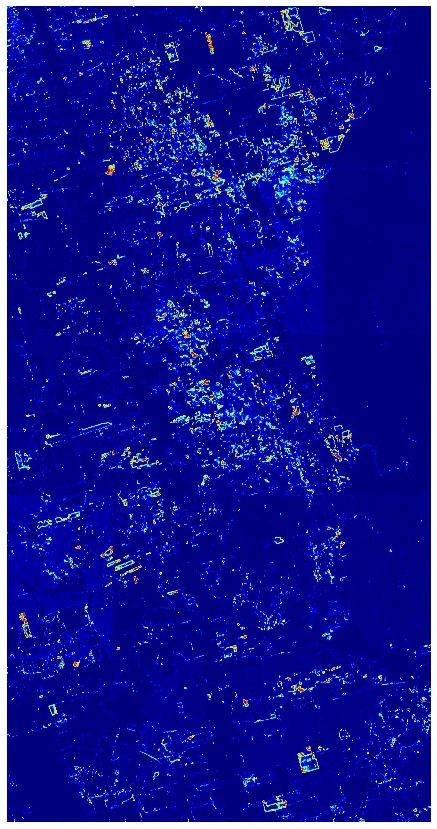

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy, cmap='jet')
plt.axis('off')


(-0.5, 9199.5, 17729.5, -0.5)

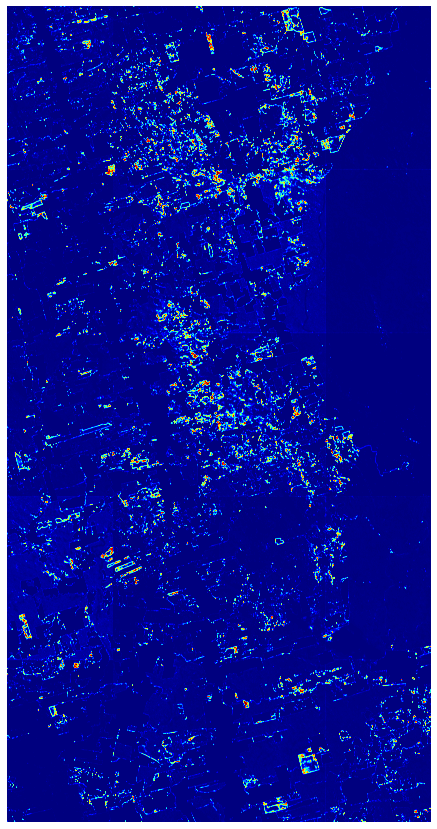

In [ ]:

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
plt.axis('off')


(-0.5, 9199.5, 17729.5, -0.5)

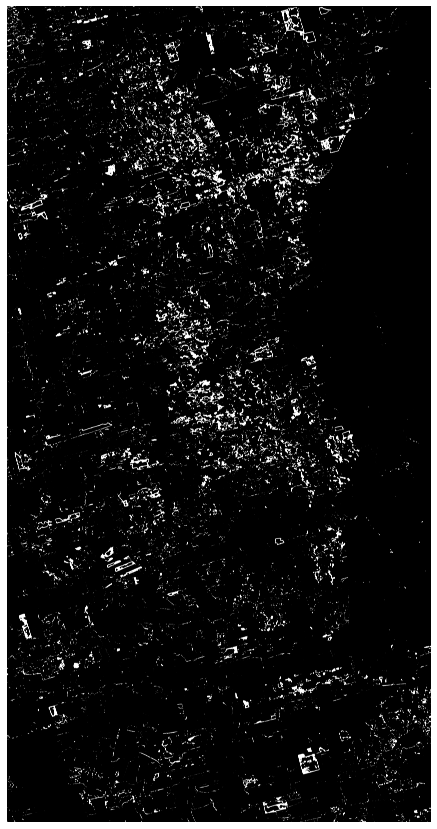

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(uncertainty_mask, cmap=plt.cm.gray)
plt.axis('off')


In [ ]:
# np.unique(label_mask_val_valid, return_counts=True)

(array([0, 1], dtype=uint8), array([9179787,  270914], dtype=int64))

In [ ]:
'''
importlib.reload(_metrics)

threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list_val = [0.1]
        # y_test
        ic(uncertainty_val.shape, label_mask_val_valid.shape)
        importlib.reload(_metrics)

        metrics_values_val = _metrics.getAA_Recall(uncertainty_val, 
                label_mask_val_valid, 
                predicted_val, threshold_list_val)

        ic(metrics_values_val)
'''


ic| uncertainty_val.shape: (9450701,)
    label_mask_val_valid.shape: (9450701,)


threshold 0.015
(7350366,) (7350366,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2100335,)
    predicted_test_classified_incorrect.shape: (2100335,)


cm_correct [[7284748    5544]
 [     95   59979]]


ic| TP_H + FN_H + FP_H + TN_H: 2100335
    len(label_mask_current_deforestation_test): 9450701
ic| TP_H + FN_H + FP_H + TN_H: 2100335
    len(label_mask_current_deforestation_test): 9450701


cm_incorrect [[1851117   38378]
 [  54430  156410]]
[0.91538849 0.99841862 0.22139498 0.22224119 0.80297554 0.74184216]
threshold 0.025
(7809542,) (7809542,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1641159,)
    predicted_test_classified_incorrect.shape: (1641159,)
ic

cm_correct [[7725125    6797]
 [    203   77417]]
cm_incorrect [[1410740   37125]
 [  54322  138972]]


| TP_H + FN_H + FP_H + TN_H: 1641159
    len(label_mask_current_deforestation_test): 9450701
ic| TP_H + FN_H + FP_H + TN_H: 1641159
    len(label_mask_current_deforestation_test): 9450701


[0.91928895 0.99738469 0.28576227 0.17365474 0.78917869 0.71896696]
threshold 0.05
(8262308,) (8262308,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1188393,)
    predicted_test_classified_incorrect.shape: (1188393,)
ic| TP_H + FN_H + FP_H + TN_H: 1188393
    len(label_mask_current_deforestation_test): 9450701
ic| TP_H + FN_H + FP_H + TN_H: 1188393
    len(label_mask_current_deforestation_test): 9450701


cm_correct [[8148115    9926]
 [    490  103777]]
cm_incorrect [[987750  33996]
 [ 54035 112612]]
[0.91270239 0.99530053 0.38306252 0.12574655 0.76811634 0.67575174]
threshold 0.08
(8512209,) (8512209,)


ic| label_current_deforestation_test_classified_incorrect.shape: (938492,)
    predicted_test_classified_incorrect.shape: (938492,)
ic| TP_H + FN_H + FP_H + TN_H: 938492
    len(label_mask_current_deforestation_test): 9450701
ic| TP_H + FN_H + FP_H + TN_H: 938492
    len(label_mask_current_deforestation_test): 9450701


cm_correct [[8372763   12946]
 [   1112  125388]]
cm_incorrect [[763102  30976]
 [ 53413  91001]]
[0.90641491 0.99120949 0.46283322 0.09930396 0.74605048 0.63013974]
threshold 0.1
(8621651,) (8621651,)


ic| label_current_deforestation_test_classified_incorrect.shape: (829050,)
    predicted_test_classified_incorrect.shape: (829050,)
ic| TP_H + FN_H + FP_H + TN_H: 829050
    len(label_mask_current_deforestation_test): 9450701
ic| TP_H + FN_H + FP_H + TN_H: 829050
    len(label_mask_current_deforestation_test): 9450701


cm_correct [[8469078   14612]
 [   1706  136255]]
cm_incorrect [[666787  29310]
 [ 52819  80134]]
[0.90314648 0.98763419 0.50294558 0.08772365 0.73219181 0.60272427]
threshold 0.15
(8816552,) (8816552,)


ic| label_current_deforestation_test_classified_incorrect.shape: (634149,)
    predicted_test_classified_incorrect.shape: (634149,)
ic| TP_H + FN_H + FP_H + TN_H: 634149
    len(label_mask_current_deforestation_test): 9450701
ic| TP_H + FN_H + FP_H + TN_H: 634149
    len(label_mask_current_deforestation_test): 9450701


cm_correct [[8636076   18905]
 [   3694  157877]]
cm_incorrect [[499789  25017]
 [ 50831  58512]]
[0.89306038 0.97713699 0.58275689 0.06710074 0.70049923 0.53512342]
threshold 0.2
(8958016,) (8958016,)


ic| label_current_deforestation_test_classified_incorrect.shape: (492685,)
    predicted_test_classified_incorrect.shape: (492685,)
ic| TP_H + FN_H + FP_H + TN_H: 492685
    len(label_mask_current_deforestation_test): 9450701
ic| TP_H + FN_H + FP_H + TN_H: 492685
    len(label_mask_current_deforestation_test): 9450701


cm_correct [[8753335   23461]
 [   5942  175278]]
cm_incorrect [[382530  20461]
 [ 48583  41111]]
[0.8819507  0.96721112 0.6469876  0.05213211 0.66768986 0.45834727]
threshold 0.25
(9076258,) (9076258,)


ic| label_current_deforestation_test_classified_incorrect.shape: (374443,)
    predicted_test_classified_incorrect.shape: (374443,)
ic| TP_H + FN_H + FP_H + TN_H: 374443
    len(label_mask_current_deforestation_test): 9450701
ic| TP_H + FN_H + FP_H + TN_H: 374443
    len(label_mask_current_deforestation_test): 9450701


cm_correct [[8847926   29009]
 [   9334  189989]]
cm_incorrect [[287939  14913]
 [ 45191  26400]]
[0.8675376  0.95317149 0.70128897 0.03962066 0.63902404 0.36876144]
threshold 0.27
(9121292,) (9121292,)


ic| label_current_deforestation_test_classified_incorrect.shape: (329409,)
    predicted_test_classified_incorrect.shape: (329409,)
ic| TP_H + FN_H + FP_H + TN_H: 329409
    len(label_mask_current_deforestation_test): 9450701
ic| TP_H + FN_H + FP_H + TN_H: 329409
    len(label_mask_current_deforestation_test): 9450701


cm_correct [[8883157   31507]
 [  11116  195512]]
cm_incorrect [[252708  12415]
 [ 43409  20877]]
[0.86121426 0.94620284 0.72167551 0.03485551 0.62708759 0.32475189]
threshold 0.3
(9191379,) (9191379,)


ic| label_current_deforestation_test_classified_incorrect.shape: (259322,)
    predicted_test_classified_incorrect.shape: (259322,)
ic| TP_H + FN_H + FP_H + TN_H: 259322
    len(label_mask_current_deforestation_test): 9450701
ic| TP_H + FN_H + FP_H + TN_H: 259322
    len(label_mask_current_deforestation_test): 9450701


cm_correct [[8937732   35626]
 [  14680  203341]]
cm_incorrect [[198133   8296]
 [ 39845  13048]]
[0.85091665 0.93266704 0.75057398 0.02743945 0.61131934 0.24668671]
threshold 0.34
(9299114,) (9299114,)


ic| label_current_deforestation_test_classified_incorrect.shape: (151587,)
    predicted_test_classified_incorrect.shape: (151587,)
ic| TP_H + FN_H + FP_H + TN_H: 151587
    len(label_mask_current_deforestation_test): 9450701
ic| TP_H + FN_H + FP_H + TN_H: 151587
    len(label_mask_current_deforestation_test): 9450701


cm_correct [[9019127   42555]
 [  22998  214434]]
cm_incorrect [[116738   1367]
 [ 31527   1955]]
[0.83440925 0.90313858 0.79152056 0.01603976 0.5885009  0.05838958]
threshold 0.36
(9374900,) (9374900,)


ic| label_current_deforestation_test_classified_incorrect.shape: (75801,)
    predicted_test_classified_incorrect.shape: (75801,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:286: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 75801
    len(label_mask_current_deforestation_test): 9450701
ic| TP_H + FN_H + FP_H + TN_H: 75801
    len(label_mask_current_deforestation_test): 9450701
ic| metrics_values_val: array([[0.91538849, 0.99841862, 0.22139498, 0.22224119, 0.80297554,
                                0.74184216],
                               [0.91928895, 0.99738469, 0.28576227, 0.17365474, 0.78917869,
                                0.71896696],
                               [0.91270239, 0.99530053, 0.38306252, 0.12574655, 0.76811634,
                                0.67575174],
                               [0.90641491, 0.99120949, 0.46283322, 0.09930396, 0.74605048,
                           

cm_correct [[9077647   43922]
 [  36942  216389]]
cm_incorrect [[58218     0]
 [17583     0]]
[0.83127106 0.85417497 0.79873687 0.00802067        nan 0.        ]


In [ ]:
'''
m_val = {'precision_L': metrics_values_val[:,0],
        'recall_L': metrics_values_val[:,1],
        'recall_Ltotal': metrics_values_val[:,2],
        'AA': metrics_values_val[:,3],
        'precision_H': metrics_values_val[:,4],
        'recall_H': metrics_values_val[:,5]}


save_figures=False
'''

In [ ]:
# threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]


In [ ]:
'''
plt.plot(m_val['precision_L']*100, m_val['AA']*100)
plt.title('Precision vs. To-Audit Area')
plt.xlabel('Precision (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/precision_AA_val.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m_val['precision_L']*100, m_val['AA']*100)\nplt.title('Precision vs. To-Audit Area')\nplt.xlabel('Precision (%)')\nplt.ylabel('Audit Area (%)')\nif True:\n    plt.savefig('figures/precision_AA_val.png', dpi=150, bbox_inches='tight')\n"

In [ ]:
'''
plt.plot(m_val['precision_L']*100, np.asarray(threshold_list_val))
plt.title('Precision vs. Threshold')
plt.xlabel('Precision (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/precision_total_threshold_val.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m_val['precision_L']*100, np.asarray(threshold_list_val))\nplt.title('Precision vs. Threshold')\nplt.xlabel('Precision (%)')\nplt.ylabel('Threshold')\nif True:\n    plt.savefig('figures/precision_total_threshold_val.png', dpi=150, bbox_inches='tight')\n"

In [ ]:
'''
plt.plot(m_val['recall_Ltotal']*100, m_val['AA']*100)
plt.title('Recall total vs. To-Audit Area')
plt.xlabel('Recall (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/recall_total_AA_val.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m_val['recall_Ltotal']*100, m_val['AA']*100)\nplt.title('Recall total vs. To-Audit Area')\nplt.xlabel('Recall (%)')\nplt.ylabel('Audit Area (%)')\nif True:\n    plt.savefig('figures/recall_total_AA_val.png', dpi=150, bbox_inches='tight')\n"

In [ ]:
'''
plt.plot(m_val['recall_Ltotal']*100, np.asarray(threshold_list_val))
plt.title('Recall total vs. Threshold')
plt.xlabel('Recall (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/recall_total_threshold_val.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m_val['recall_Ltotal']*100, np.asarray(threshold_list_val))\nplt.title('Recall total vs. Threshold')\nplt.xlabel('Recall (%)')\nplt.ylabel('Threshold')\nif True:\n    plt.savefig('figures/recall_total_threshold_val.png', dpi=150, bbox_inches='tight')\n"

In [ ]:
'''
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, label="precision_L")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, m_val['recall_L']*100, label="Recall_L")
ax2.plot(m_val['AA']*100, m_val['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')
'''

'\nfig, (ax1, ax2, ax3) = plt.subplots(1, 3)\nfig.set_figheight(5)\nfig.set_figwidth(15)\nax1.plot(m_val[\'AA\']*100, m_val[\'precision_L\']*100, label="precision_L")\nax1.plot(m_val[\'AA\']*100, m_val[\'precision_H\']*100, label="precision_H")\nax1.legend(loc="lower right")\nax1.set_ylabel(\'%\')\nax1.set_xlabel(\'Audit Area (%)\')\n\nax2.plot(m_val[\'AA\']*100, m_val[\'recall_L\']*100, label="Recall_L")\nax2.plot(m_val[\'AA\']*100, m_val[\'recall_H\']*100, label="Recall_H")\nax2.legend(loc="lower right")\nax2.set_ylabel(\'%\')\nax2.set_xlabel(\'Audit Area (%)\')\n\nax3.plot(m_val[\'AA\']*100, np.asarray(threshold_list_val), label="AA")\nax3.set_xlabel(\'Audit Area (%)\')\nax3.set_ylabel(\'Threshold\')\n\n# if save_figures == True:\nif True:\n    plt.savefig(\'figures/recall_precision_AA_val.png\', dpi=150, bbox_inches=\'tight\')\n'

In [ ]:
'''
m_val['f1_L'] = 2*m_val['precision_L']*m_val['recall_L']/(m_val['precision_L']+m_val['recall_L'])
m_val['f1_H'] = 2*m_val['precision_H']*m_val['recall_H']/(m_val['precision_H']+m_val['recall_H'])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['f1_L']*100, label="f1_L")
ax1.plot(m_val['AA']*100, m_val['f1_H']*100, label="f1_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/f1_AA_val.png', dpi=150, bbox_inches='tight')
'''

'\nm_val[\'f1_L\'] = 2*m_val[\'precision_L\']*m_val[\'recall_L\']/(m_val[\'precision_L\']+m_val[\'recall_L\'])\nm_val[\'f1_H\'] = 2*m_val[\'precision_H\']*m_val[\'recall_H\']/(m_val[\'precision_H\']+m_val[\'recall_H\'])\n\nfig, (ax1, ax2) = plt.subplots(1, 2)\nfig.set_figheight(5)\nfig.set_figwidth(15)\nax1.plot(m_val[\'AA\']*100, m_val[\'f1_L\']*100, label="f1_L")\nax1.plot(m_val[\'AA\']*100, m_val[\'f1_H\']*100, label="f1_H")\nax1.legend(loc="lower right")\nax1.set_ylabel(\'%\')\nax1.set_xlabel(\'Audit Area (%)\')\n\nax2.plot(m_val[\'AA\']*100, np.asarray(threshold_list_val), label="AA")\nax2.set_xlabel(\'Audit Area (%)\')\nax2.set_ylabel(\'Threshold\')\n\n# if save_figures == True:\nif True:\n    plt.savefig(\'figures/f1_AA_val.png\', dpi=150, bbox_inches=\'tight\')\n'

In [ ]:
'''
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, 'C0-', label="Precision Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_L']*100, 'C0--', label="Recall Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, 'C1-', label="Precision High Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_H']*100, 'C1--', label="Recall High Uncertainty")
ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)

ax2.plot(m_val['AA']*100, m_val['f1_L']*100, label="F1 Low Uncertainty")
ax2.plot(m_val['AA']*100, m_val['f1_H']*100, label="F1 High Uncertainty")
ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')
ax3.set_xlim(xlim)

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')
'''

'\nfig, (ax1, ax2, ax3) = plt.subplots(1, 3)\nfig.set_figheight(5)\nfig.set_figwidth(15)\nax1.plot(m_val[\'AA\']*100, m_val[\'precision_L\']*100, \'C0-\', label="Precision Low Uncertainty")\nax1.plot(m_val[\'AA\']*100, m_val[\'recall_L\']*100, \'C0--\', label="Recall Low Uncertainty")\nax1.plot(m_val[\'AA\']*100, m_val[\'precision_H\']*100, \'C1-\', label="Precision High Uncertainty")\nax1.plot(m_val[\'AA\']*100, m_val[\'recall_H\']*100, \'C1--\', label="Recall High Uncertainty")\nax1.legend(loc="lower right")\nax1.set_ylabel(\'Precision/recall (%)\')\nax1.set_xlabel(\'Audit Area (%)\')\nax1.set_ylim(ylim)\nax1.set_xlim(xlim)\n\nax2.plot(m_val[\'AA\']*100, m_val[\'f1_L\']*100, label="F1 Low Uncertainty")\nax2.plot(m_val[\'AA\']*100, m_val[\'f1_H\']*100, label="F1 High Uncertainty")\nax2.legend(loc="lower right")\nax2.set_ylabel(\'F1 score (%)\')\nax2.set_xlabel(\'Audit Area (%)\')\nax2.set_ylim(ylim)\nax2.set_xlim(xlim)\n\nax3.plot(m_val[\'AA\']*100, np.asarray(threshold_list_val), lab